In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
numpy2ri.activate()
import scanpy.api as sc
import scipy as sp
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.set_figure_params(dpi_save=300, format='pdf')
sc.settings.figdir = './figures/'

scanpy==1.3.3 anndata==0.6.10 numpy==1.14.5 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Read data

In [2]:
adata = sc.read('./zebrafish_neurogenesis_smartseq.h5ad')

In [3]:
adata.obs = adata.obs.rename(columns={'cell.type': 'sort_gate'})

In [4]:
adata.var_names = list(adata.var['Symbol'])

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata.var_names_make_unique()

In [6]:
adata = adata[:, ~adata.var['is_feature_control_ERCC']]

In [7]:
adata.obs['sort_gate'].cat.reorder_categories(['RG', 'NBN', 'ON'], inplace=True)
adata.obs['sort_gate'].cat.rename_categories({'ON': 'MN'}, inplace=True)

In [8]:
adata_original = adata.copy()

# Genes of interest

In [9]:
markers = {}

# correct marker names
markers['RG'] = ['her4.1', 'cx43', 'id1', 's100b']
markers['NBN'] = ['elavl3', 'map2', 'insm1a']
markers['MN'] = ['sv2a', 'nrgna', 'camk2a']
markers['proliferation'] = ['ccnd1', 'mki67', 'mcm5']
markers['pseudotime'] = ['sox4a', 'sox4b', 'sox11a', 'insm1a', 'insm1b', 'eomesa', 'neurod1', 'neurod4',
                         'neurod6a', 'neurod6b', 'slc17a6a', 'slc17a6b', 'dlx1a', 'dlx2a', 'dlx5a', 'gad1b', 'gad2', 'emx3']

Test whether all markers are in gene list. Remove markers that are not.

In [10]:
ok = True
for key, item in markers.items():
    for marker in item:
        try:
            adata_original.var.loc[marker]
        except:
            print('Removing', key, 'marker', marker)
            item.remove(marker)
            ok = False
if ok:
    print('All markers in gene list')

All markers in gene list


In [11]:
all_markers = []
for key, markerlist in markers.items():
    for marker in markerlist:
        all_markers.append(marker)
markers['all'] = np.unique(all_markers)

In [12]:
markers['christian'] = markers['RG'] + markers['NBN'] + markers['MN']

In [13]:
print(markers['christian'])

['her4.1', 'cx43', 'id1', 's100b', 'elavl3', 'map2', 'insm1a', 'sv2a', 'nrgna', 'camk2a']


In [14]:
markers['2A'] = ['her4.1', 'cx43', 's100b', 'id1', 'elavl3', 'map2', 'insm1a', 'sv2a', 'nrgna', 'camk2a']

# Preprocessing

## Summary statistics of sequencing

In [15]:
adata.obs[['total_counts', 'total_features_by_counts']].describe()

total_counts  total_features_by_counts
count     370.000000                370.000000
mean   214541.072973               1452.670270
std    136085.806097                956.723754
min       627.000000                125.000000
25%    111523.250000                633.250000
50%    190830.500000               1407.500000
75%    319417.250000               2035.750000
max    571547.000000               9066.000000

## Quality Control

Number of cells before QC:

In [16]:
print(f'Total number of cells before QC: {adata.n_obs}')
print('Distribution on sorts:')
sorts_before = adata.obs.groupby('sort_gate').size()
print(sorts_before)

Total number of cells before QC: 370
Distribution on sorts:
sort_gate
RG     171
NBN    169
MN      30
dtype: int64


In [17]:
min_log10_counts = 4.5
min_log10_features = 2.7
max_log10_features = 3.9
max_Mito = 20
max_ERCC=25
min_mapped = 0.2
max_pct_counts_top50 = 50

n_cells0 = adata.n_obs

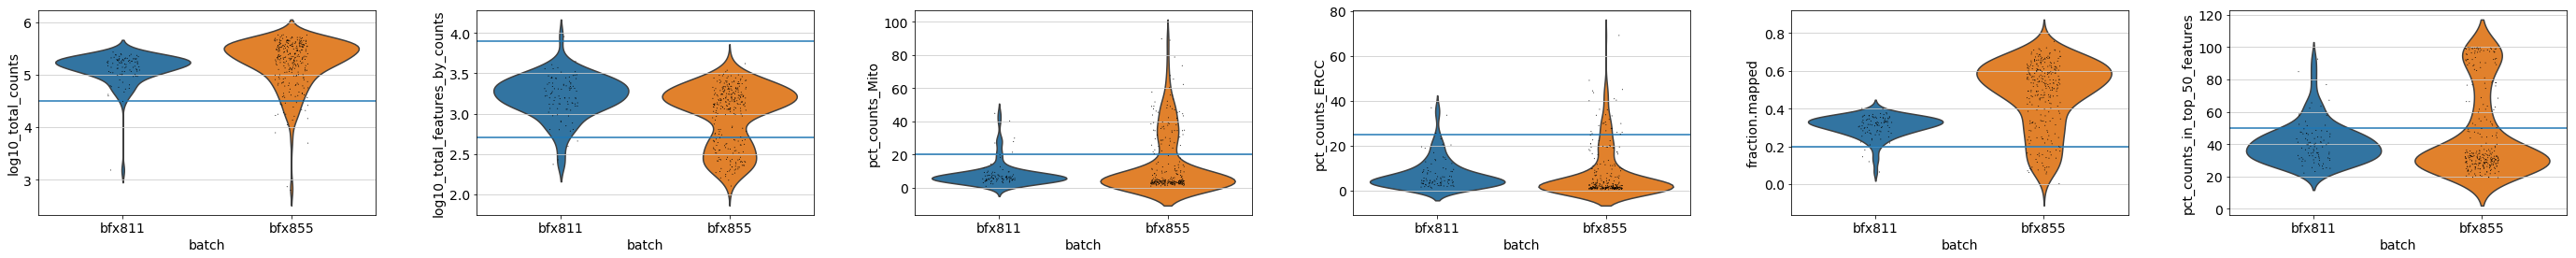

In [18]:
axs = sc.pl.violin(adata, 
             ['log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped', 'pct_counts_in_top_50_features'], 
             groupby='batch', show=False)
axs[0].axhline(min_log10_counts)
axs[1].axhline(min_log10_features)
axs[1].axhline(max_log10_features)
axs[2].axhline(max_Mito)
axs[3].axhline(max_ERCC)
axs[4].axhline(min_mapped)
axs[5].axhline(max_pct_counts_top50)
plt.show()

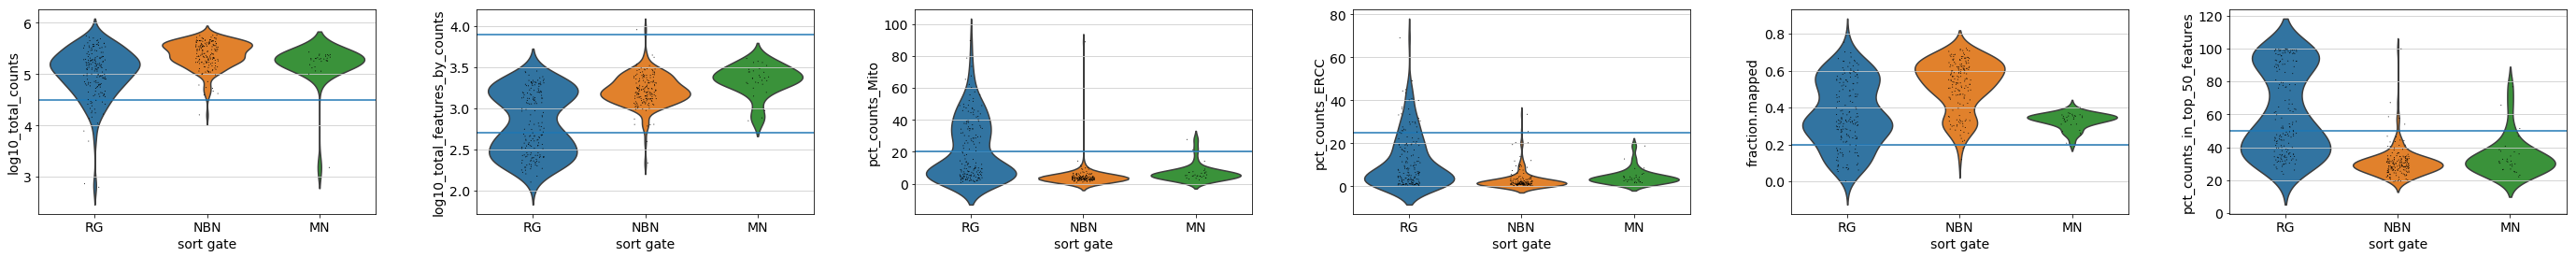

In [19]:
axs = sc.pl.violin(adata, 
             ['log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped', 'pct_counts_in_top_50_features'], 
             groupby='sort_gate', show=False)
axs[0].axhline(min_log10_counts)
axs[1].axhline(min_log10_features)
axs[1].axhline(max_log10_features)
axs[2].axhline(max_Mito)
axs[3].axhline(max_ERCC)
axs[4].axhline(min_mapped)
axs[5].axhline(max_pct_counts_top50)
plt.show()

In [20]:
adata = adata[adata.obs['log10_total_counts'] > min_log10_counts]
adata = adata[adata.obs['log10_total_features_by_counts'] > min_log10_features]
adata = adata[adata.obs['log10_total_features_by_counts'] < max_log10_features]
adata = adata[adata.obs['pct_counts_Mito'] < max_Mito]
adata = adata[adata.obs['pct_counts_ERCC'] < max_ERCC]
adata = adata[adata.obs['fraction.mapped'] > min_mapped]
adata = adata[adata.obs['pct_counts_in_top_50_features'] < max_pct_counts_top50]
print(f'Filtered {n_cells0 - adata.n_obs} cells. Remaining cells: {adata.n_obs}')

Filtered 106 cells. Remaining cells: 264


In [21]:
adata.obs.groupby('sort_gate').size()

sort_gate
RG      76
NBN    162
MN      26
dtype: int64

In [22]:
df1 = pd.DataFrame(sorts_before, columns=['cells']).reset_index()
df1['when'] = 'before QC'
df2 = pd.DataFrame(adata.obs.groupby('sort_gate').size(), columns=['cells']).reset_index()
df2['when'] = 'after QC'
df = pd.concat([df1, df2])
df

sort_gate  cells       when
0        RG    171  before QC
1       NBN    169  before QC
2        MN     30  before QC
0        RG     76   after QC
1       NBN    162   after QC
2        MN     26   after QC

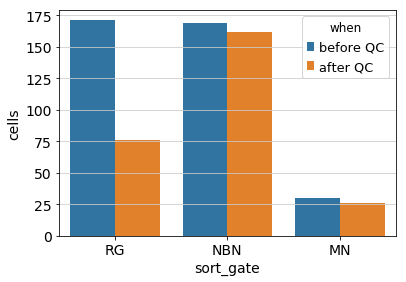

In [23]:
sns.barplot(data=df, x='sort_gate', y='cells', hue='when')
plt.show()

## HVGs

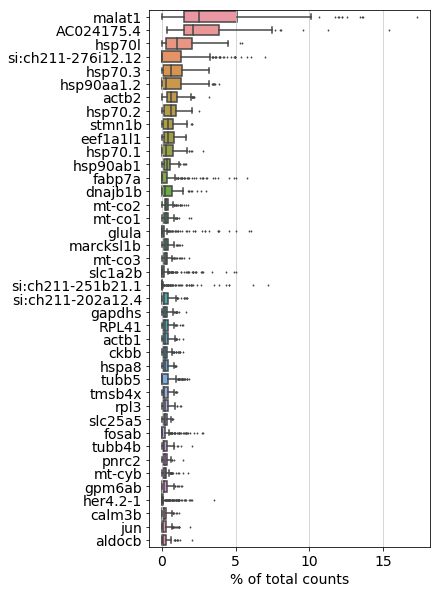

In [24]:
sc.pl.highest_expr_genes(adata, n_top=40)

In [25]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14960 genes that are detected in less than 3 cells


In [26]:
sc.pp.log1p(adata)

In [27]:
sc.pp.highly_variable_genes(adata, max_mean=8.0)

In [28]:
print(f'HVGs: {adata.var["highly_variable"].sum()}')

HVGs: 5142


In [29]:
# sc.pl.highly_variable_genes(adata)

## Normalization

### Library Size

Perform this to set the normalisation flag:

In [30]:
# sc.pp.normalize_per_cell(adata)
# sc.pp.log1p(adata)

### Scran

Use all "detectable" genes for normalisation.

In [31]:
adata_scran = adata_original[adata.obs_names].copy()

In [32]:
sc.pp.filter_genes(adata_scran, min_cells=3)

filtered out 14960 genes that are detected in less than 3 cells


In [33]:
robjects.globalenv['counts'] = adata_scran.X.T
adata.obs['sizeFactor'] = robjects.r(
    """
    suppressPackageStartupMessages(library(scater))
    suppressPackageStartupMessages(library(scran))
    clusters <- quickCluster(counts, method="igraph", min.mean=1.0,
    irlba.args=list(maxit=1000))
    computeSumFactors(counts, min.mean=1.0, cluster=clusters)
    """)

In [34]:
adata.obs['log10_sizeFactor'] = np.log10(adata.obs['sizeFactor'])

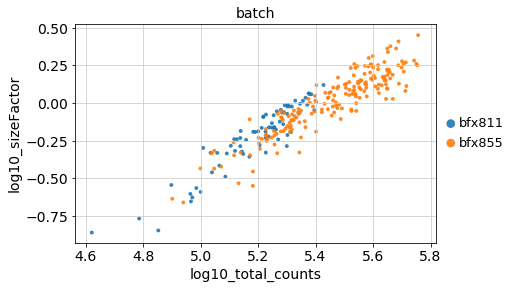

In [35]:
sc.pl.scatter(adata, x='log10_total_counts', y='log10_sizeFactor', size=60, alpha=0.9,
             color='batch')

In [36]:
adata.X = sp.sparse.csr_matrix(adata_original[adata.obs_names][:, adata.var_names].X.T 
                     / adata.obs['sizeFactor'].values.astype(np.float32)
                    ).T

In [37]:
sc.pp.log1p(adata)

## Scale

In [38]:
sc.pp.scale(adata)

## Store raw data

In [39]:
adata.raw = sc.pp.log1p(adata_original[adata.obs_names], copy=True)


# Fig. 2A

In [40]:
sc.set_figure_params(dpi=80, format='pdf')

In [41]:
plot_data = adata.obs[['sort_gate']].copy()

In [42]:
for marker in markers['2A']:
    plot_data[marker] = np.log(adata_original[plot_data.index][:, marker].X.copy() + 1)

In [43]:
# plot_data.loc[:,'her4.1':] = plot_data.loc[:,'her4.1':] / plot_data.loc[:,'her4.1':].max()

In [44]:
# with sns.color_palette('Set2'):
#     fig, axs = plt.subplots(3, 4, sharex=False, sharey=True, figsize=(3.1,6.5))
#     for gene, ax in zip(markers['2A'][:4], axs[0]):
#         sns.violinplot(x='sort_gate', y=gene, data=plot_data, ax=ax, scale='width', inner=None)
#         sns.stripplot(x='sort_gate', y=gene, data=plot_data, ax=ax, color='black', size=1)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_title(gene)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size='small')

#     for gene, ax in zip(markers['2A'][4:7], axs[1][:3]):
#         sns.violinplot(x='sort_gate', y=gene, data=plot_data, ax=ax, scale='width', inner=None)
#         sns.stripplot(x='sort_gate', y=gene, data=plot_data, ax=ax, color='black', size=1)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_title(gene)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size='small')

#     for gene, ax in zip(markers['2A'][7:10], axs[2][:3]):
#         sns.violinplot(x='sort_gate', y=gene, data=plot_data, ax=ax, scale='width', inner=None)
#         sns.stripplot(x='sort_gate', y=gene, data=plot_data, ax=ax, color='black', size=1)
#         ax.set_xlabel('')
#         ax.set_ylabel('')
#         ax.set_title(gene)
#         ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, size='small')

#     axs[0,0].set_ylabel('Log reads')
#     axs[1,0].set_ylabel('Log reads')
#     axs[2,0].set_ylabel('Log reads')
#     axs[1,3].remove()
#     axs[2,3].remove()
#     ax.set_ylim(-1.9, None)
#     plt.tight_layout(0, 2, 0)
#     plt.savefig('../../results/figures/stacked_violin_2A.pdf', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.close()

# PCA

In [45]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)

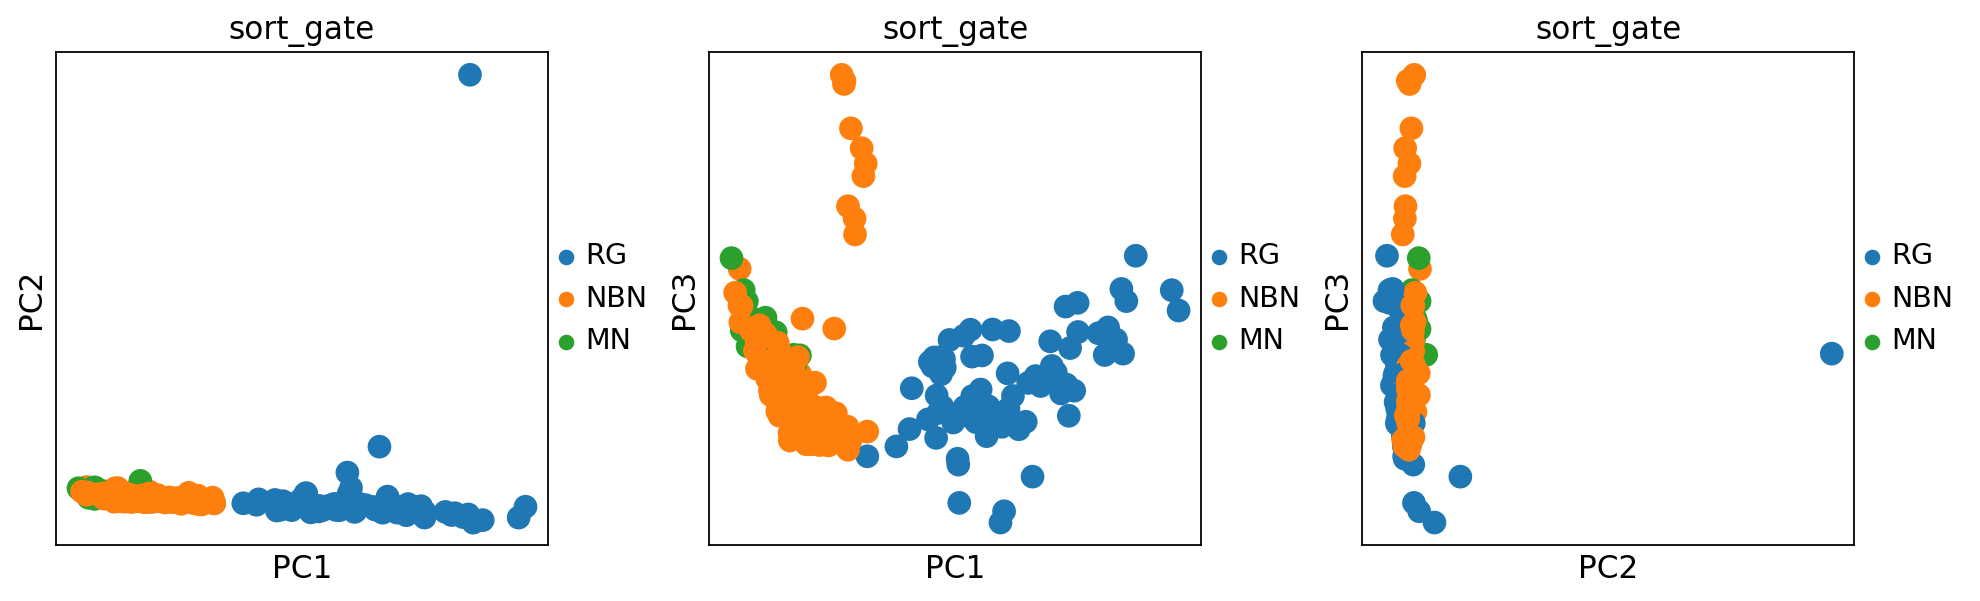

In [46]:
sc.pl.pca(adata, components=['1,2', '1,3', '2,3'], color='sort_gate')

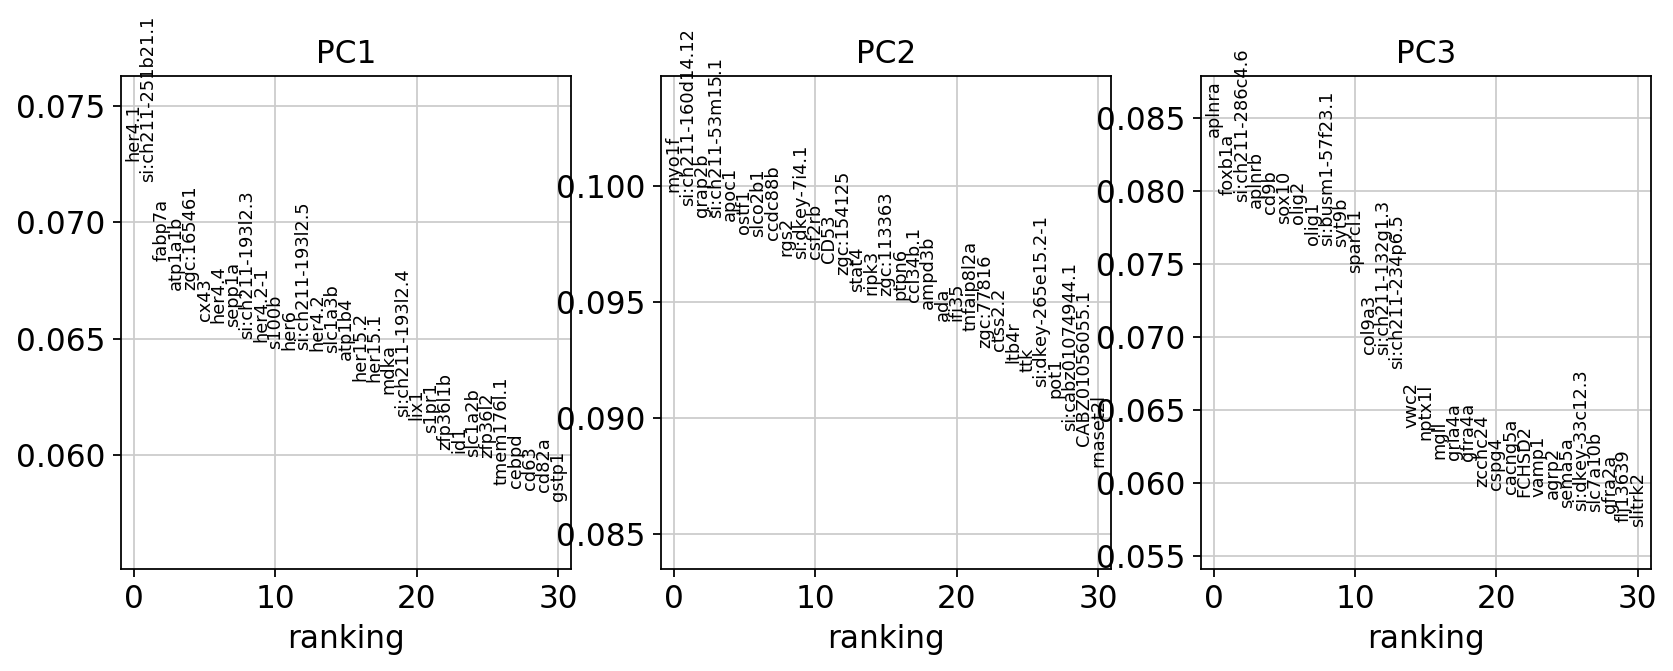

In [47]:
sc.pl.pca_loadings(adata)

In [48]:
genes_PC2 = adata.var.iloc[adata.varm['PCs'][:,1].argsort()[::-1]].index[:4]

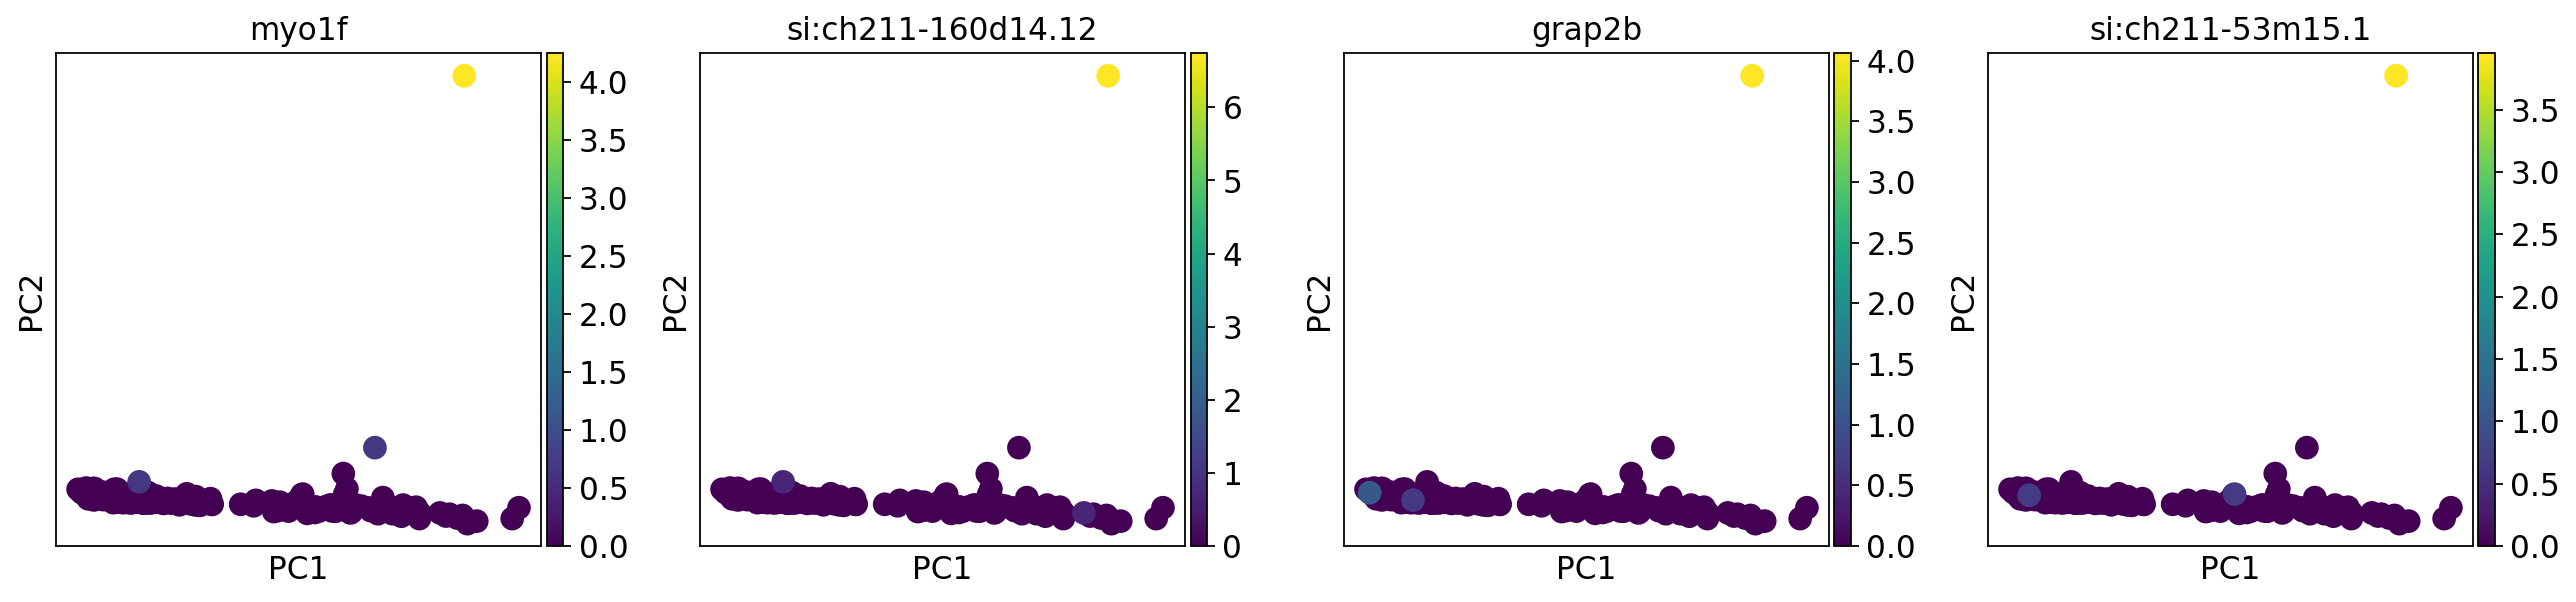

In [49]:
sc.pl.pca(adata, color=genes_PC2)

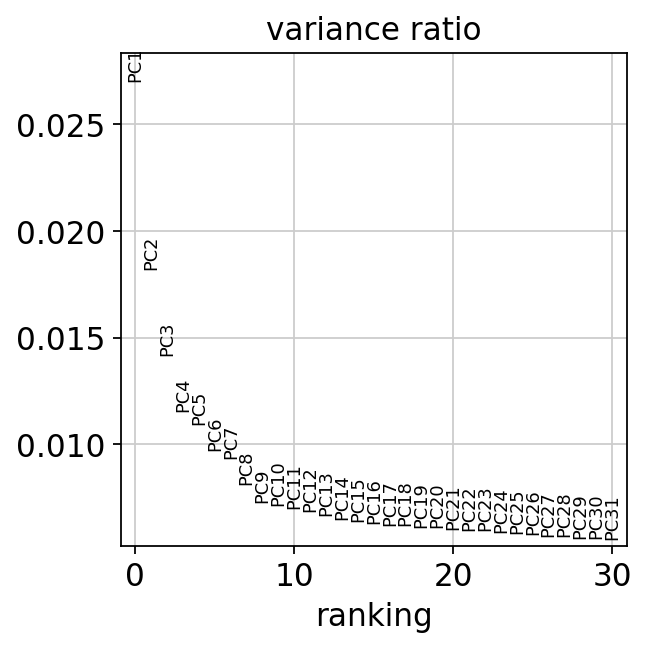

In [50]:
sc.pl.pca_variance_ratio(adata)

In [51]:
adata.uns['pca']['variance_ratio'][:15].sum()

0.15656213

## Quality on PCA:

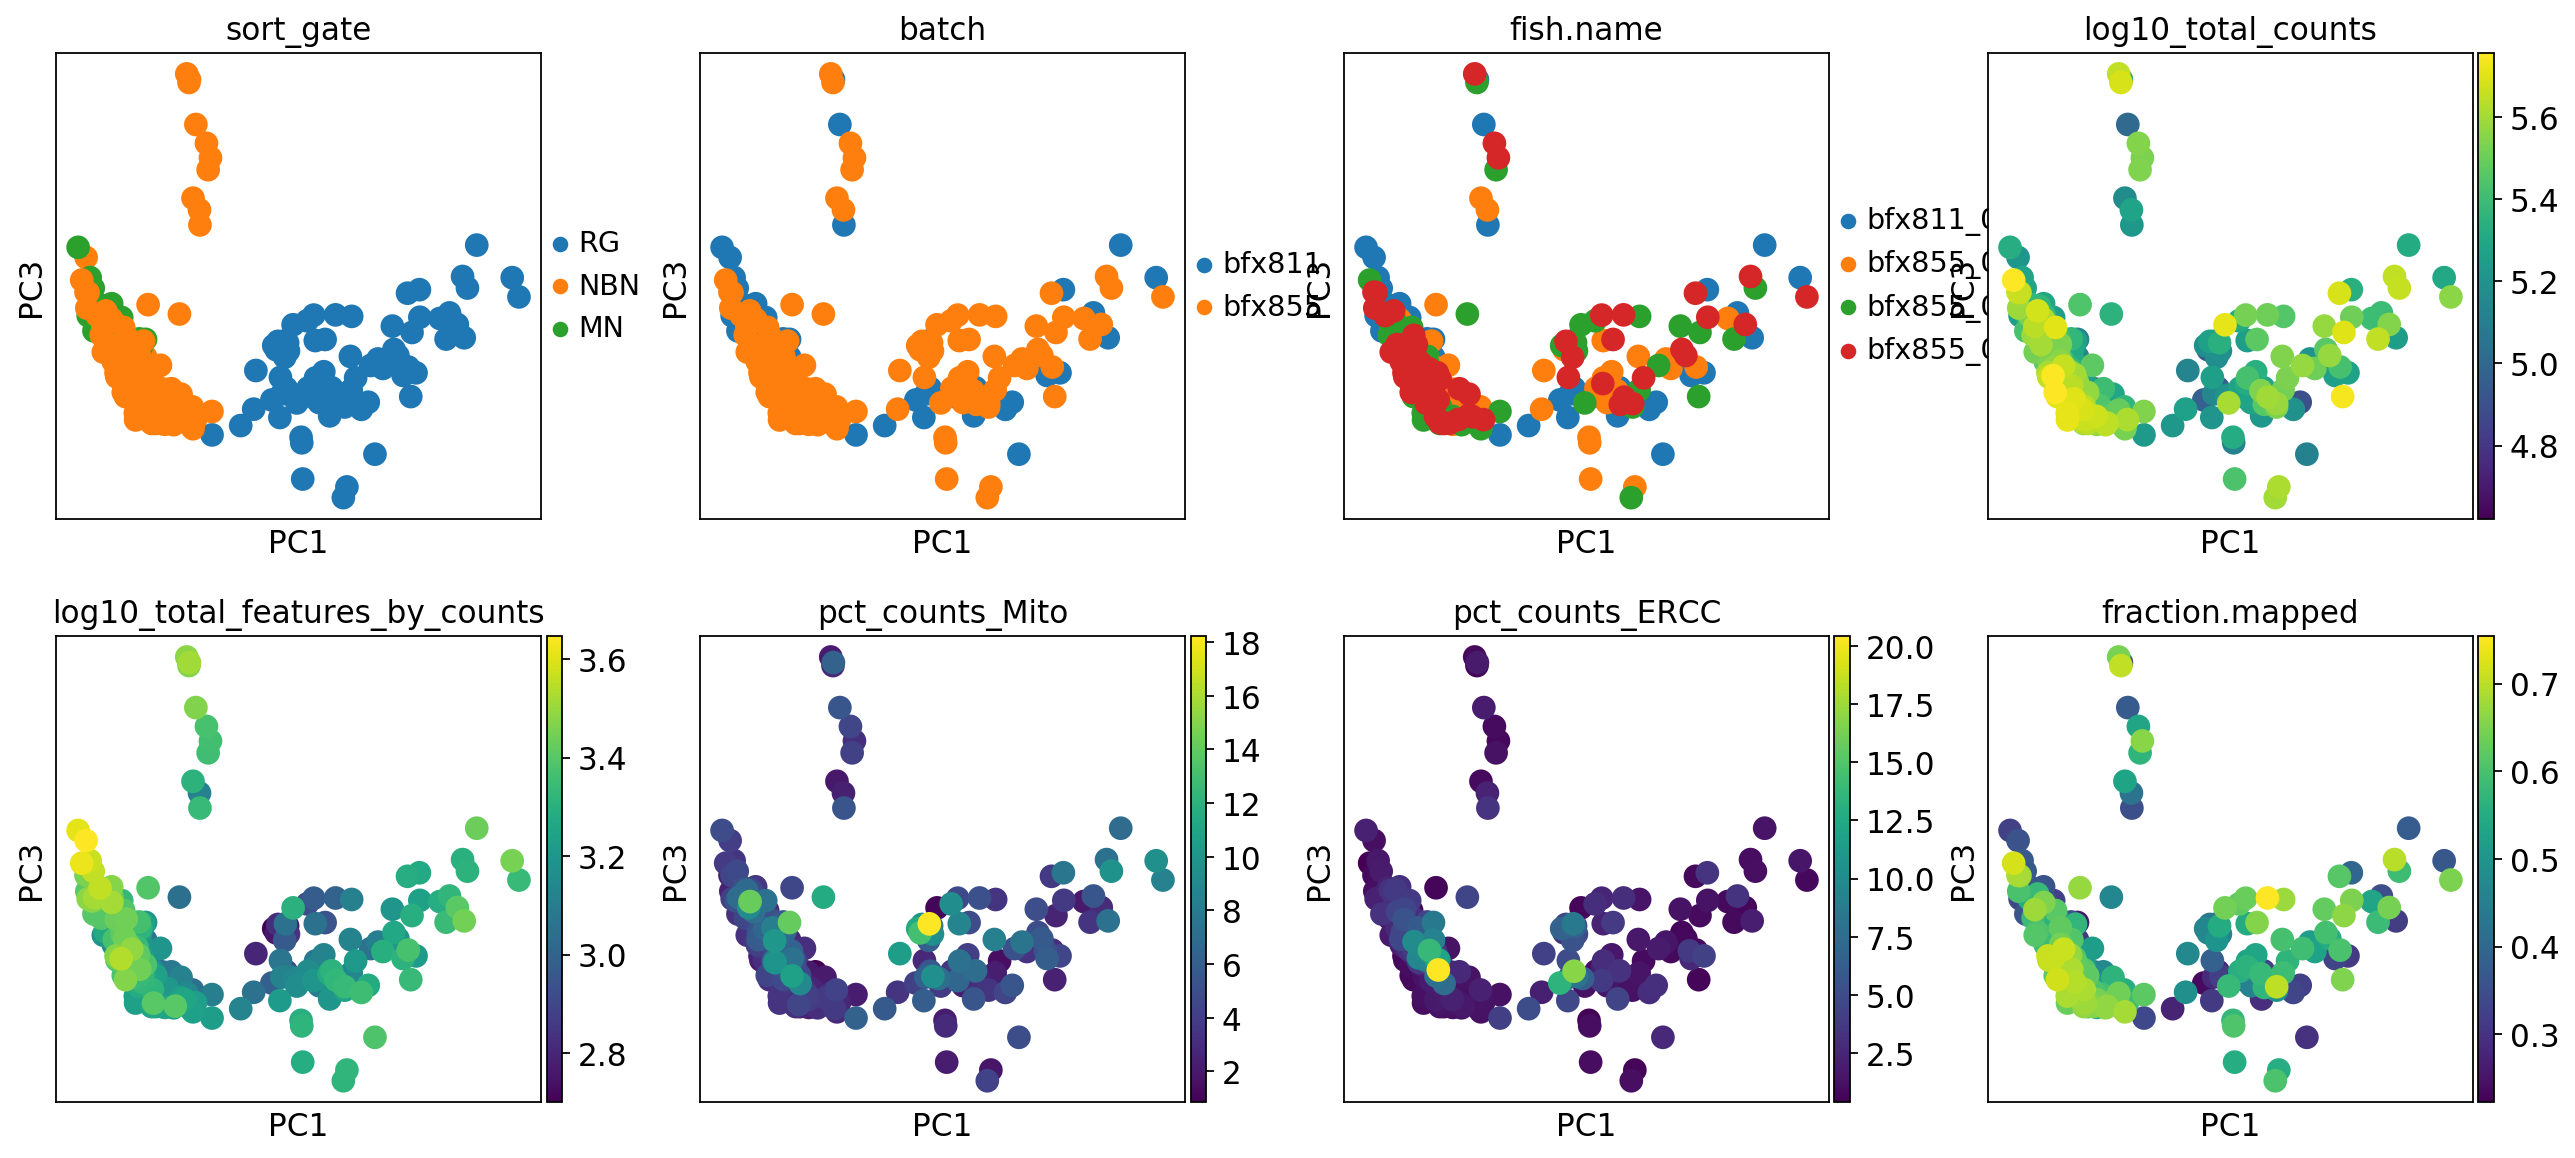

In [52]:
# sc.pl.pca(adata, color=['sort_gate', 'batch', 'fish.name', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
#               'pct_counts_ERCC', 'fraction.mapped'], components=['1,2'])
sc.pl.pca(adata, color=['sort_gate', 'batch', 'fish.name', 'log10_total_counts', 'log10_total_features_by_counts', 'pct_counts_Mito',
              'pct_counts_ERCC', 'fraction.mapped'], components=['1,3'])

# tsnE

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:01.07) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:00.98) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


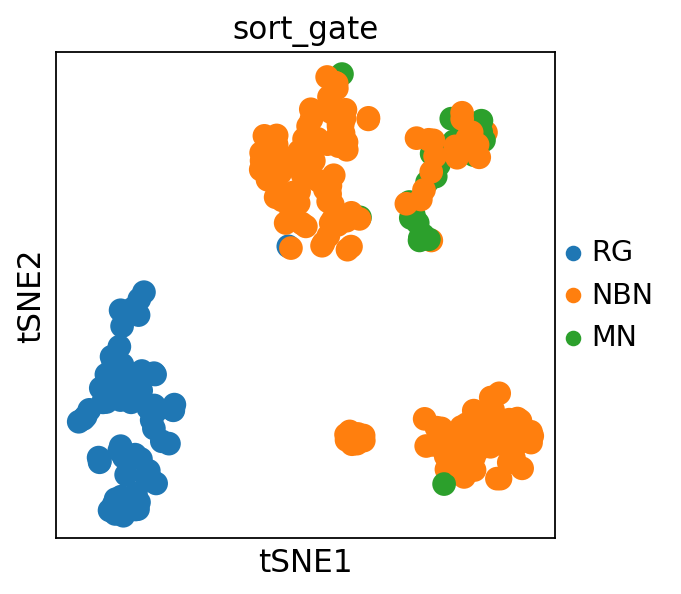

In [53]:
sc.tl.tsne(adata, n_pcs=10, random_state=1, n_jobs=10, perplexity=15)
sc.tl.tsne(adata, n_pcs=10, random_state=1, n_jobs=10, perplexity=15)
sc.pl.tsne(adata, color='sort_gate')

# UMAP

computing neighbors
    using 'X_pca' with n_pcs = 10


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:03.56) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.69) --> added
    'X_umap', UMAP coordinates (adata.obsm)


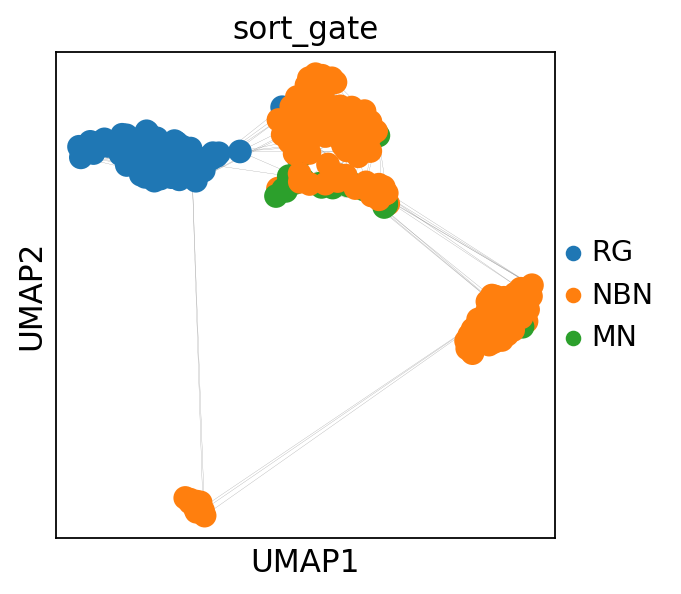

In [54]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color='sort_gate', edges=True)

# Diffusion Map

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00.01) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.0000001  0.99110854 0.98986876 0.98613155 0.97614384 0.9715326
     0.95523995 0.9369764  0.9229472  0.91546625 0.91148317 0.90654314
     0.9023228  0.8862993  0.86983746]
    finished (0:00:00.03) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


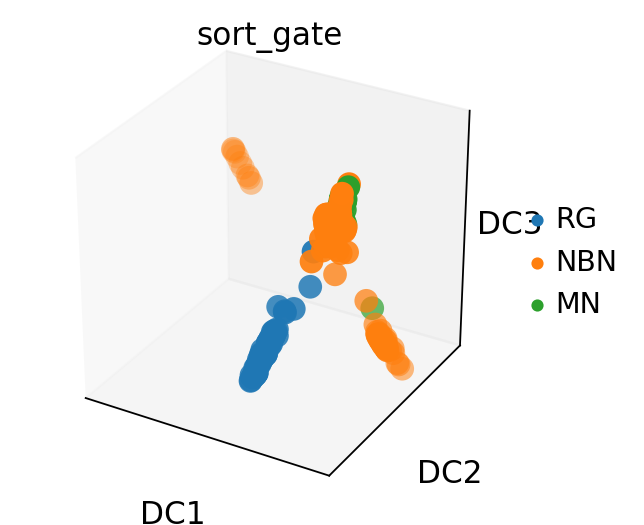

In [55]:
# sc.pp.neighbors(adata, n_neighbors=80, n_pcs=10)
sc.pp.neighbors(adata, method='gauss', knn=False, n_neighbors=5, n_pcs=10, random_state=21)
sc.tl.diffmap(adata)
sc.pl.diffmap(adata, color='sort_gate', projection='3d')
# sc.pl.diffmap(adata, color='louvain', components=['1,2', '1,3', '2,3'])
plt.show()

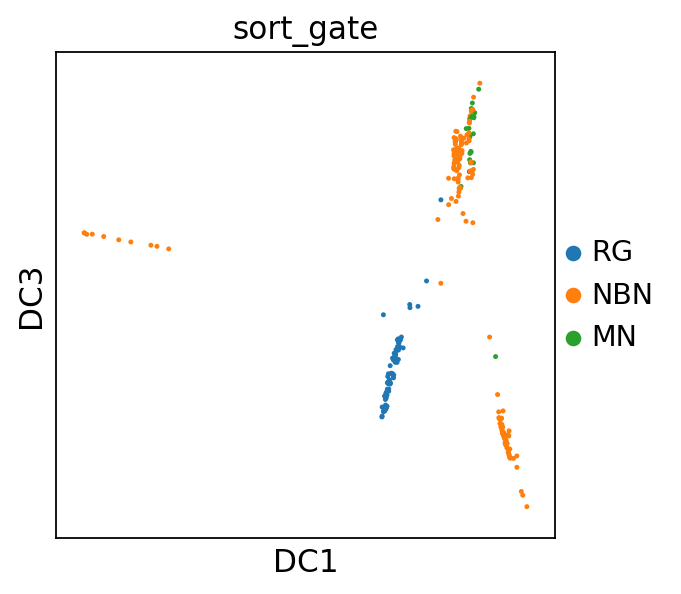

In [56]:
sc.pl.diffmap(adata, color=['sort_gate'], components=['1,3'], size=20)

# Clustering

In [57]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)
sc.tl.louvain(adata, resolution=0.5, random_state=1)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00.07) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


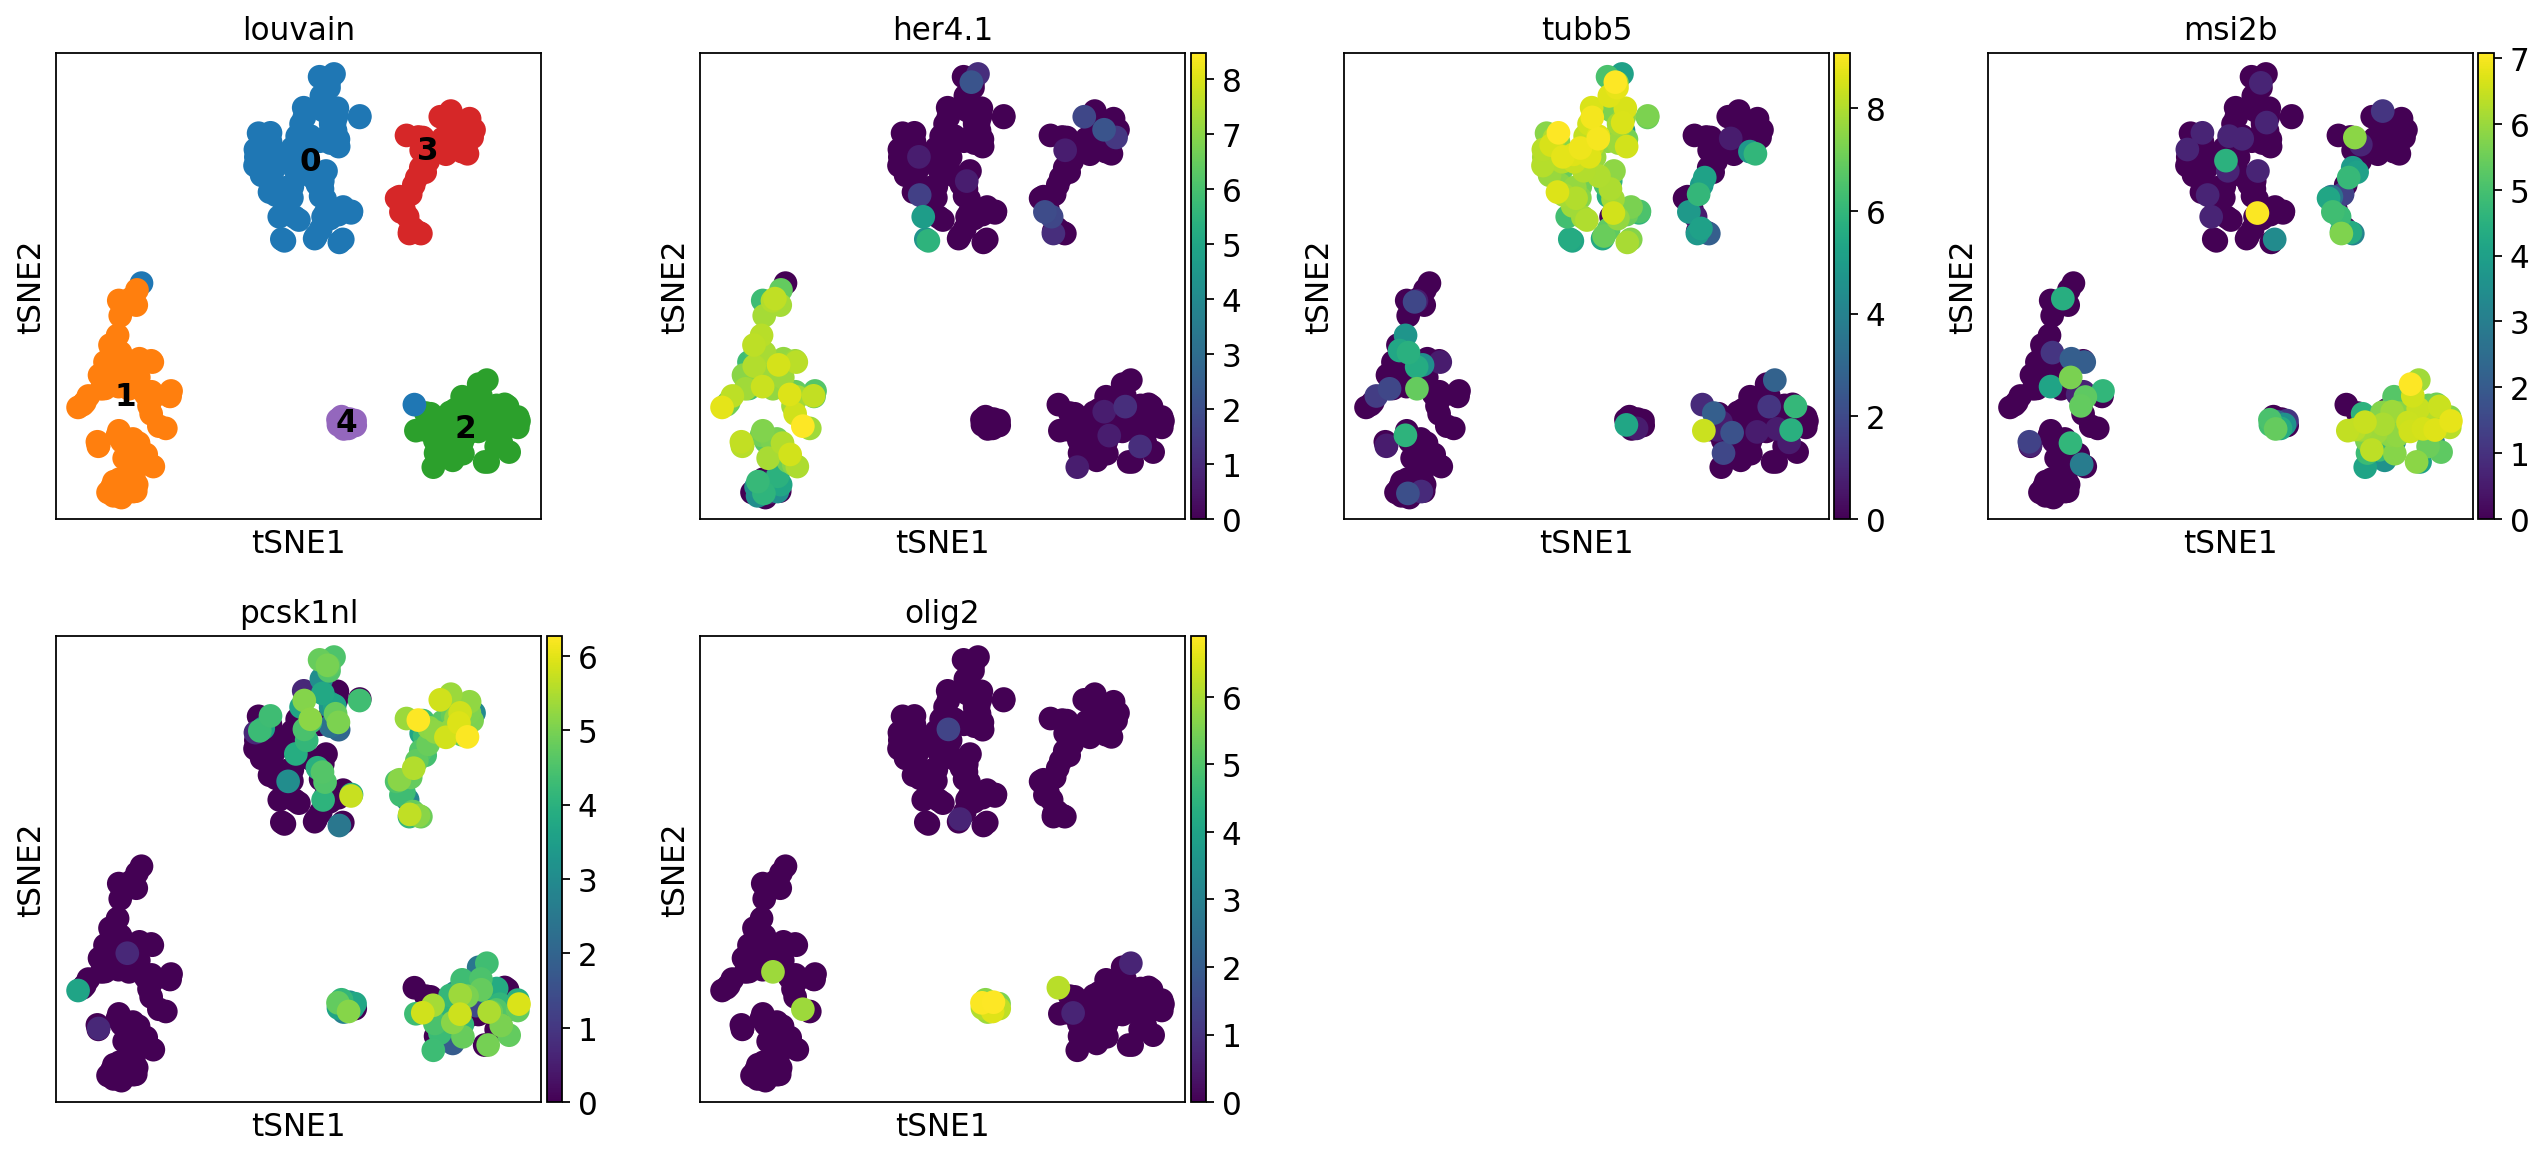

In [58]:
sc.pl.tsne(adata, color=['louvain', 'her4.1', 'tubb5', 'msi2b', 'pcsk1nl', 'olig2'], legend_loc='on data')

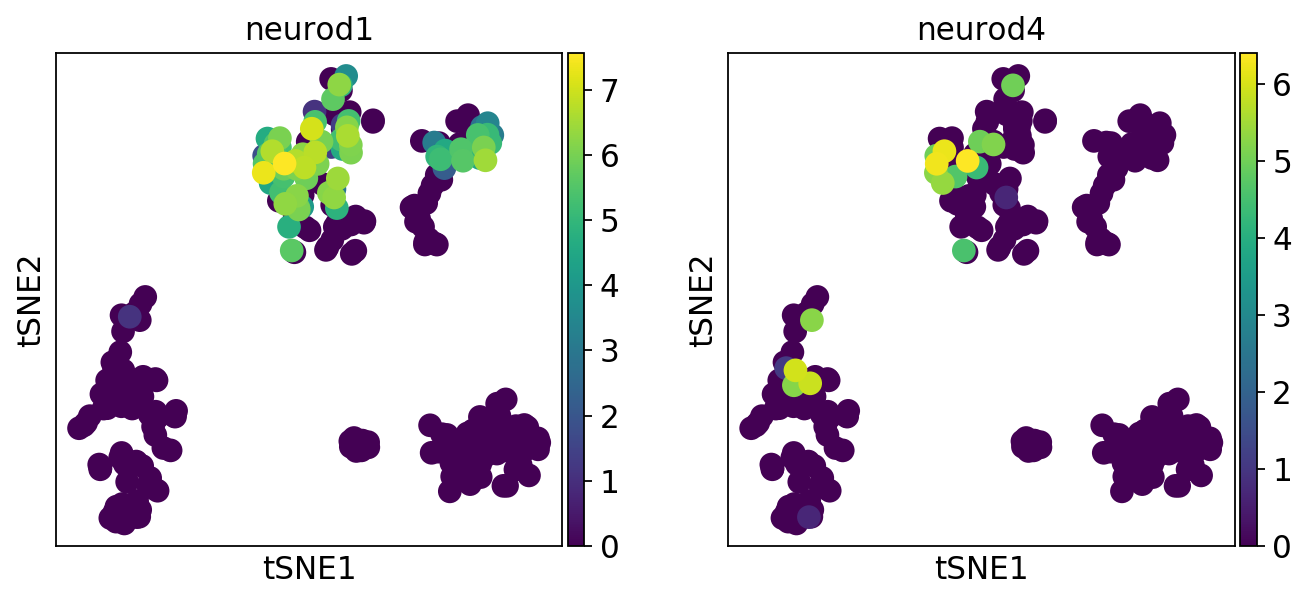

In [59]:
sc.pl.tsne(adata, color=['neurod1', 'neurod4'])

In [60]:
adata.rename_categories('louvain', ['NBN.1', 'RG',  'NBN.2', 'MN', 'OPC'])
adata.obs['louvain'].cat.reorder_categories(['RG', 'NBN.1', 'NBN.2', 'MN', 'OPC'], 
                                            inplace = True)

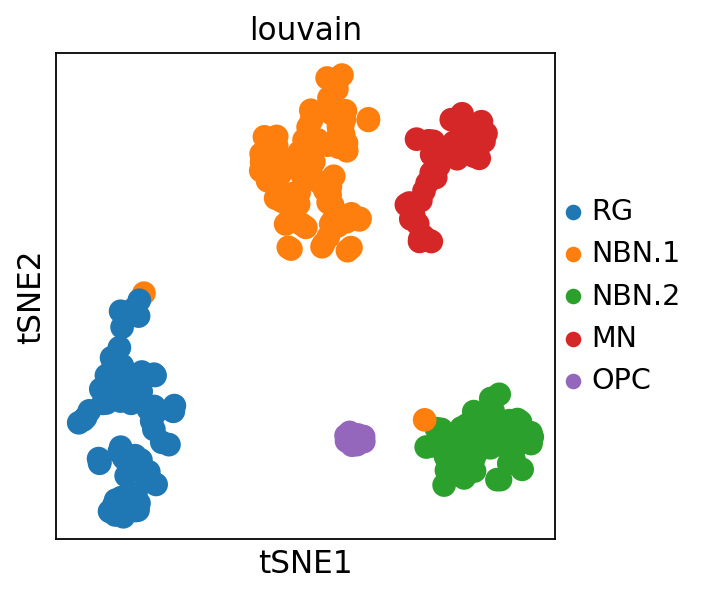

In [61]:
sc.pl.tsne(adata, color='louvain')

## Finer clustering

In [62]:
sc.settings.verbosity = 3

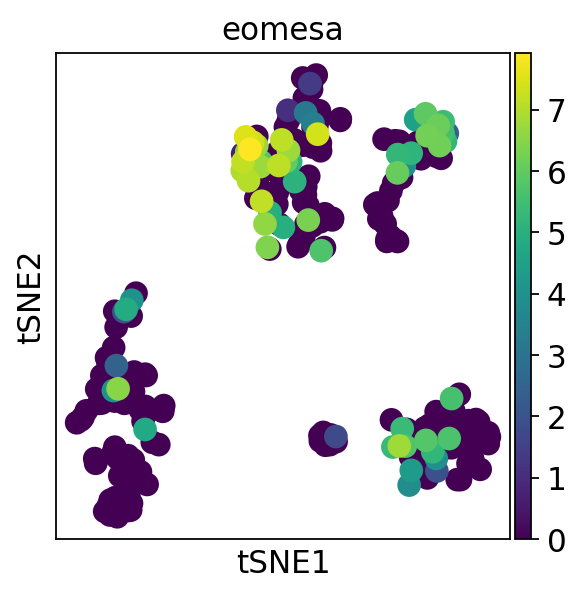

In [63]:
sc.pl.tsne(adata, color='eomesa')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 8 clusters and added
    'louvain_fine', the cluster labels (adata.obs, categorical)


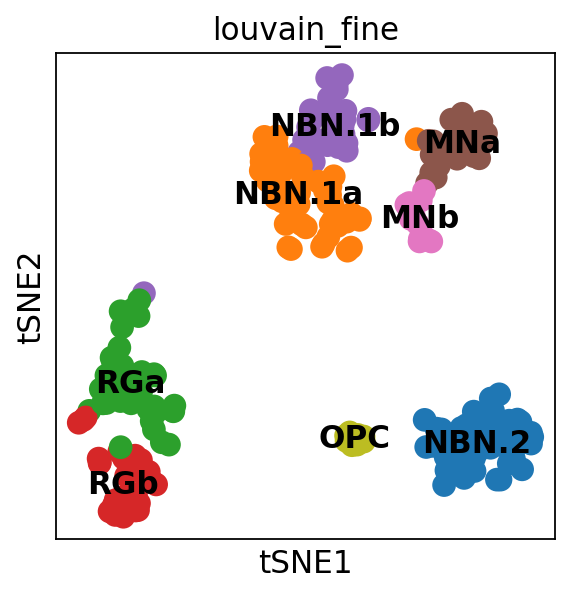

In [64]:
sc.tl.louvain(adata, resolution=0.83, key_added='louvain_fine')
adata.rename_categories('louvain_fine', ['NBN.2', 'NBN.1a', 'RGa', 'RGb', 'NBN.1b', 'MNa', 'MNb', 'OPC'])
sc.pl.tsne(adata, color=['louvain_fine'], legend_loc='on data')

In [65]:
adata.obs['louvain_fine'].value_counts()

NBN.2     56
NBN.1a    51
RGa       43
NBN.1b    31
RGb       31
MNa       29
MNb       13
OPC       10
Name: louvain_fine, dtype: int64

ranking genes
    finished (0:00:00.62) --> added to `.uns['rank_genes_louvain_fine']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


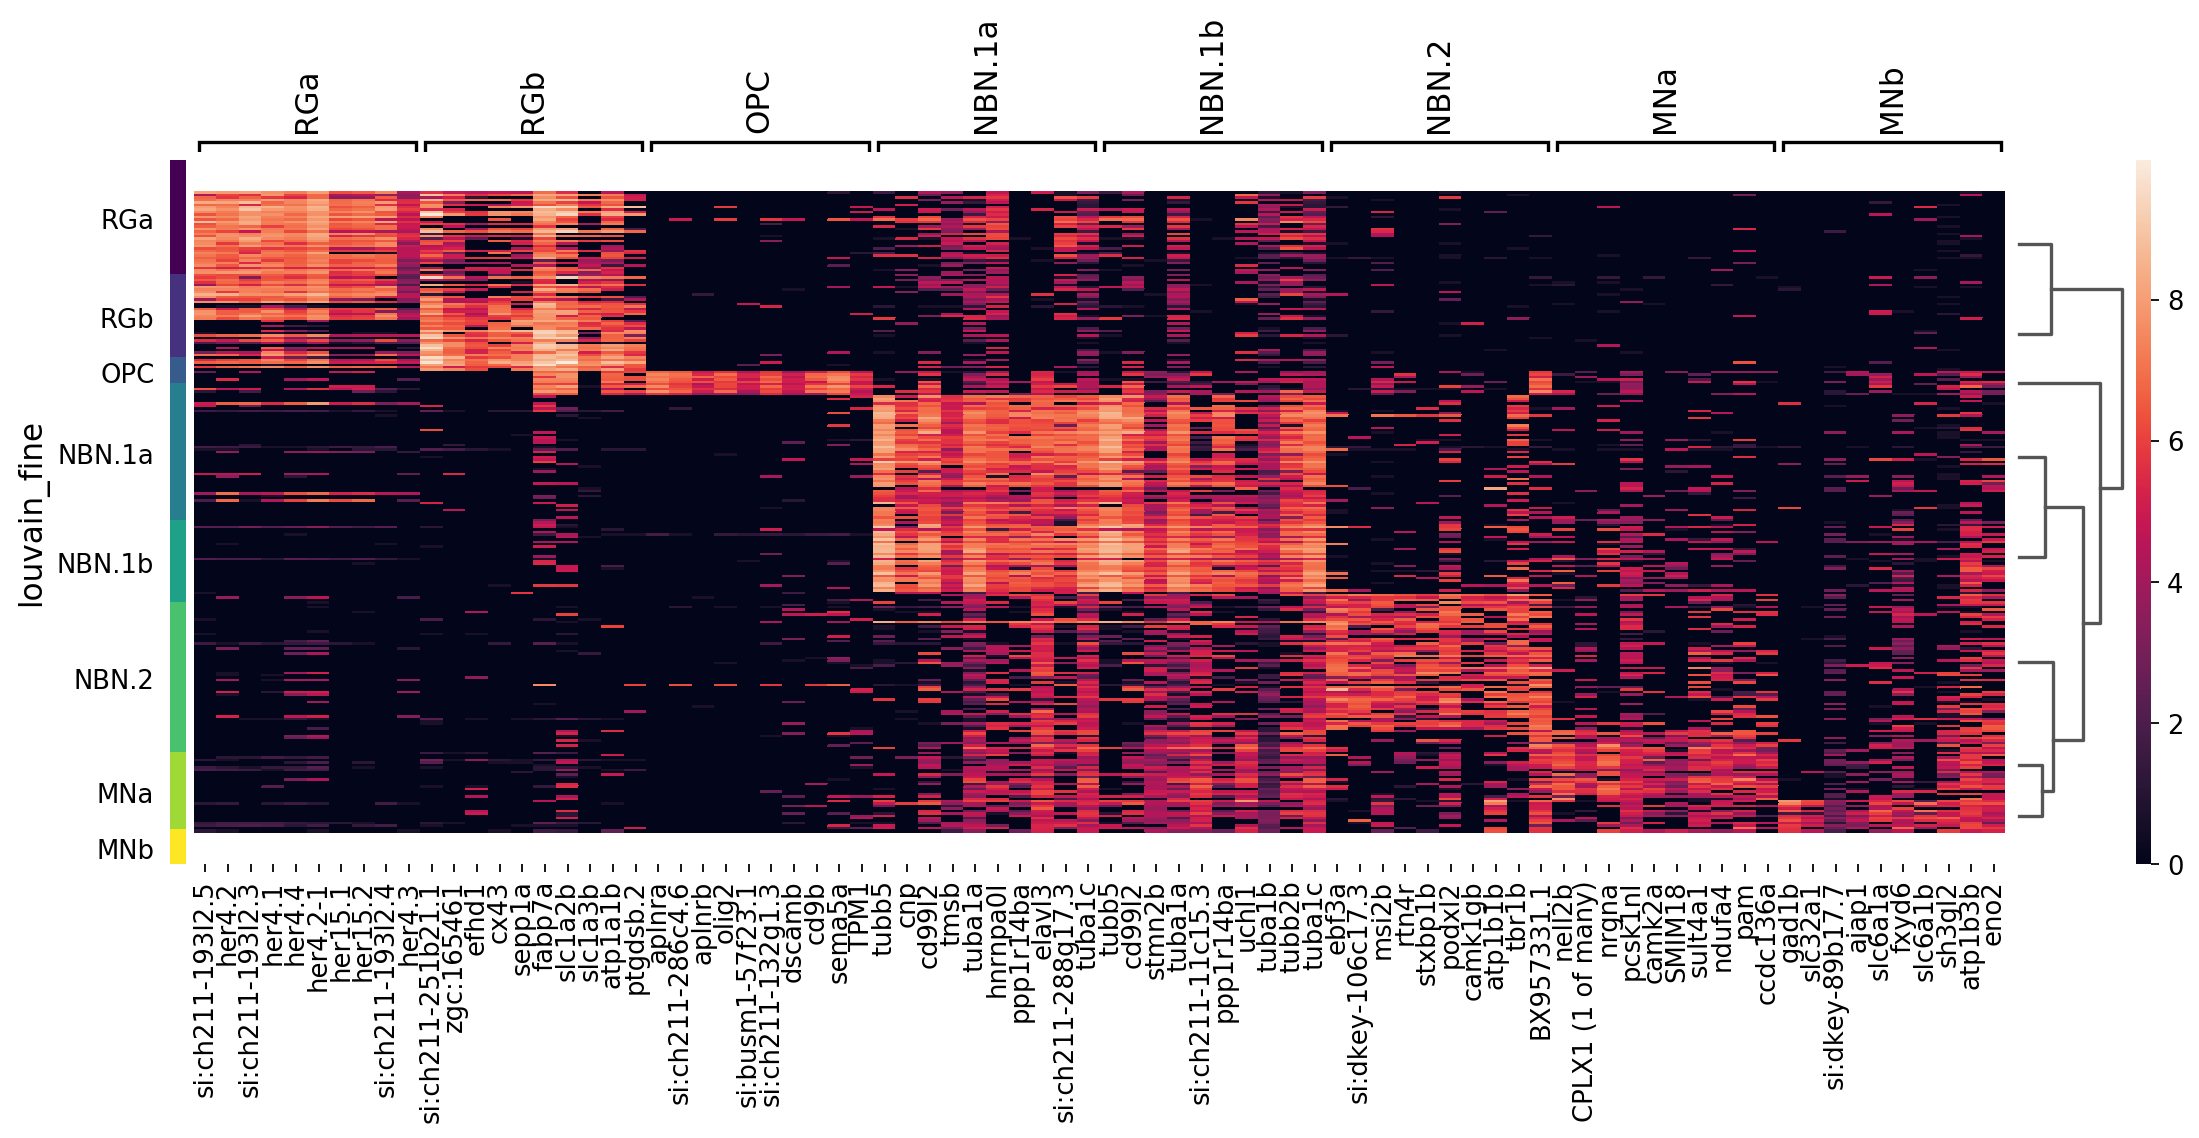

In [66]:
sc.tl.rank_genes_groups(adata, 'louvain_fine', key_added='rank_genes_louvain_fine')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_louvain_fine', dendrogram=True)

In [67]:
adata.obs['louvain_fine'].value_counts()

NBN.2     56
NBN.1a    51
RGa       43
NBN.1b    31
RGb       31
MNa       29
MNb       13
OPC       10
Name: louvain_fine, dtype: int64

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.00) --> found 2 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical)


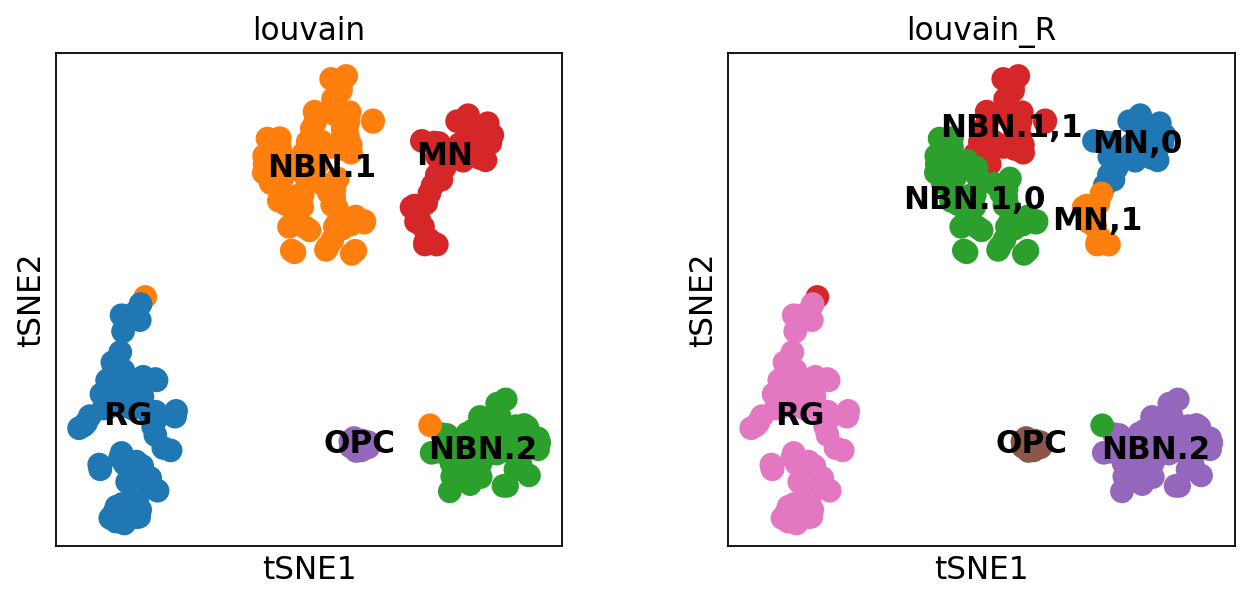

In [68]:
sc.tl.louvain(adata, resolution=0.3, restrict_to=('louvain', ['NBN.1']))
sc.tl.louvain(adata, resolution=0.3, restrict_to=('louvain_R', ['MN']), key_added='louvain_R')
sc.pl.tsne(adata, color=['louvain', 'louvain_R'], legend_loc='on data')

ranking genes
    finished (0:00:00.76) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


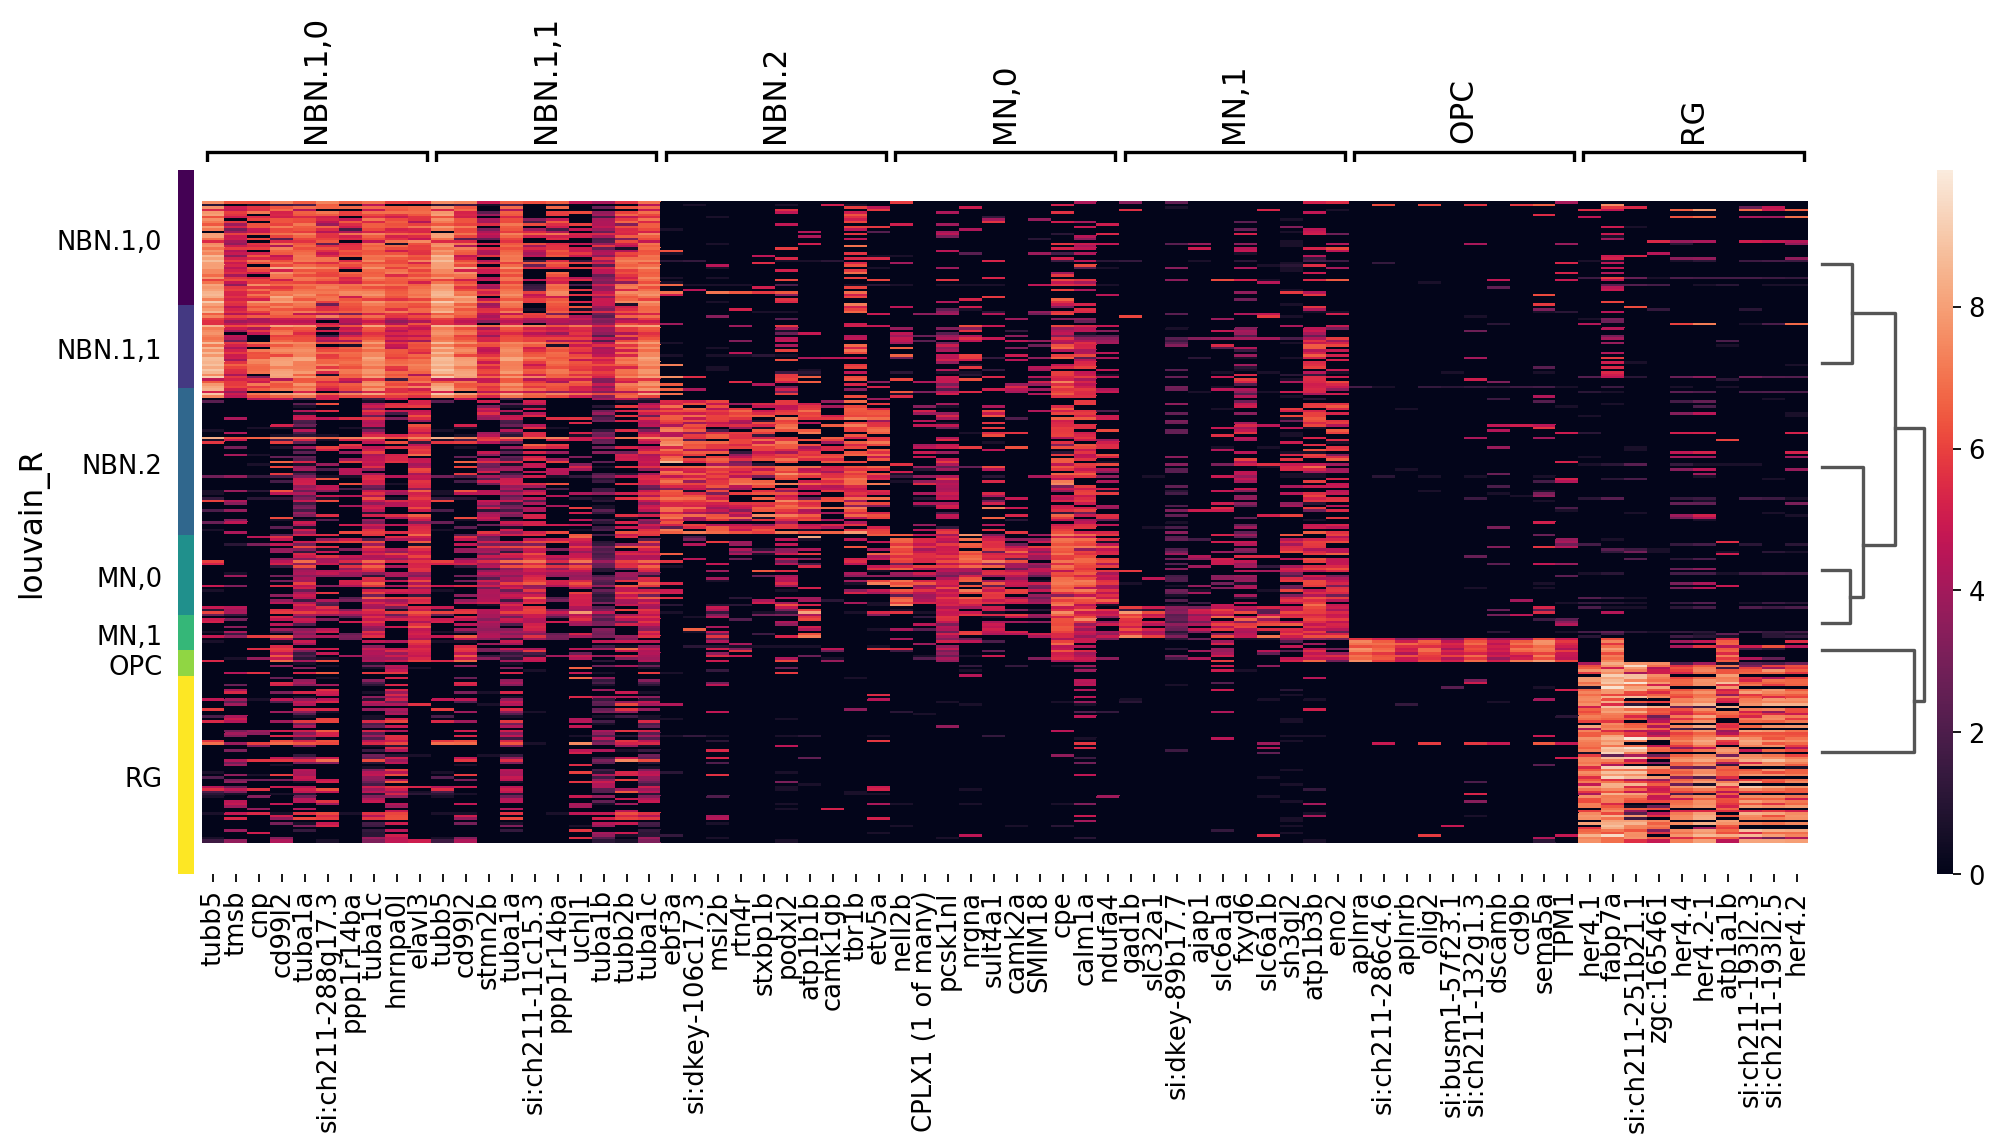

In [69]:
sc.tl.rank_genes_groups(adata, 'louvain_R')
sc.pl.rank_genes_groups_heatmap(adata)

ranking genes
    finished (0:00:00.17) --> added to `.uns['rank_genes_MN,1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.18) --> added to `.uns['rank_genes_MN,0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


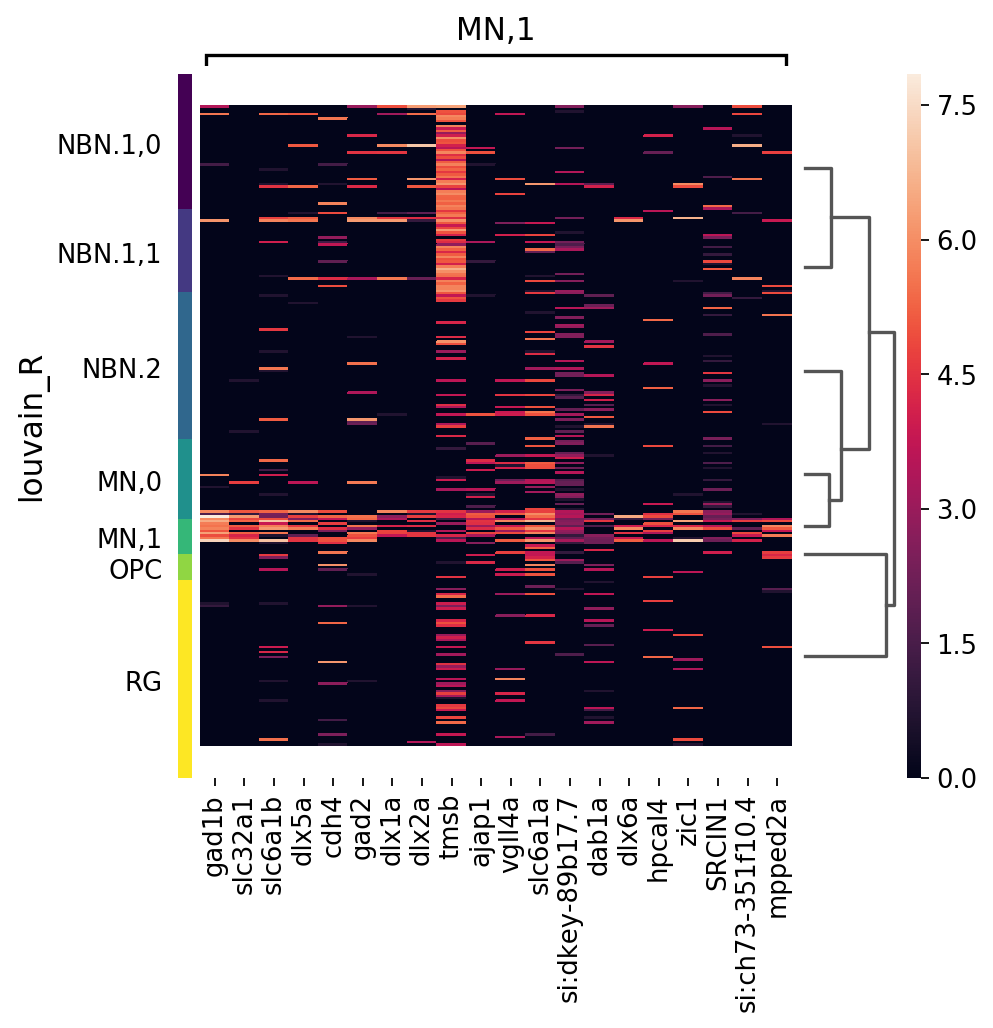

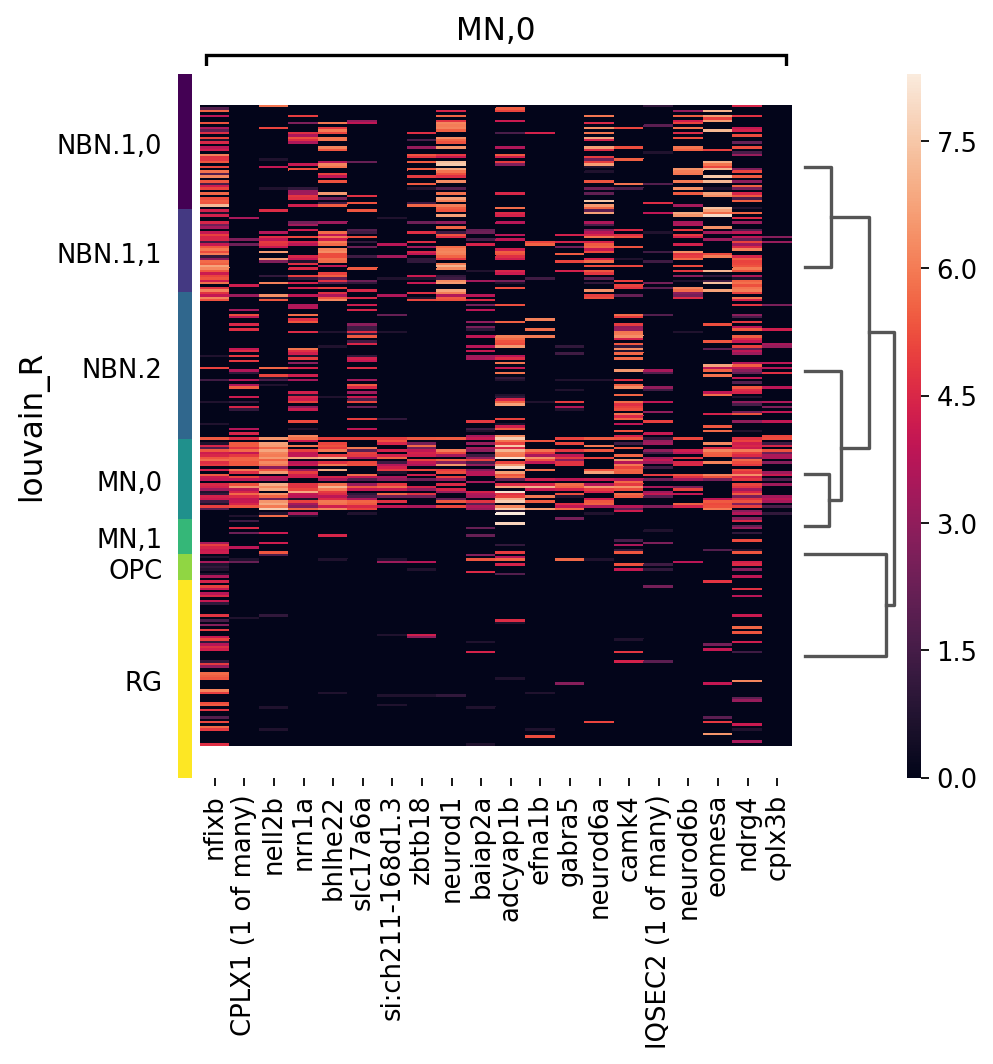

In [70]:
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['MN,0'], key_added='rank_genes_MN,1', reference='MN,1')
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['MN,1'], key_added='rank_genes_MN,0', reference='MN,0')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_MN,0', n_genes=20)
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_MN,1', n_genes=20)

ranking genes
    finished (0:00:00.14) --> added to `.uns['rank_genes_NBN.1,1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids
ranking genes
    finished (0:00:00.13) --> added to `.uns['rank_genes_NBN.1,0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


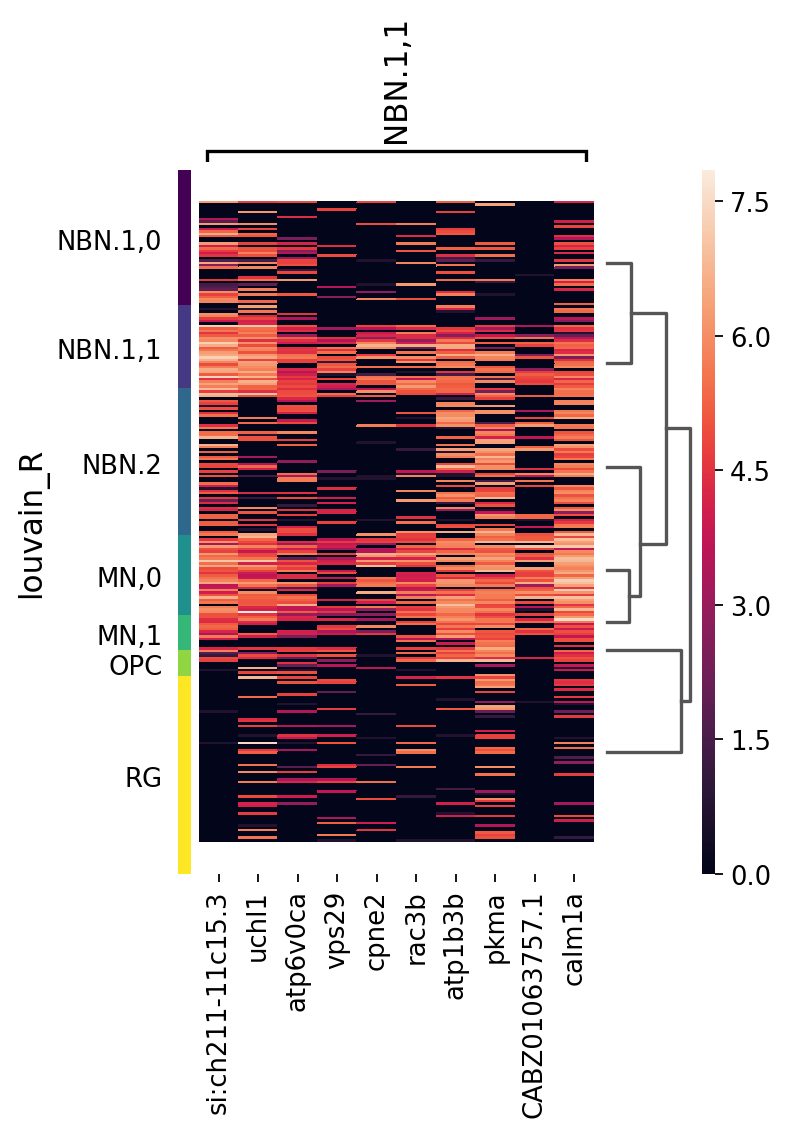

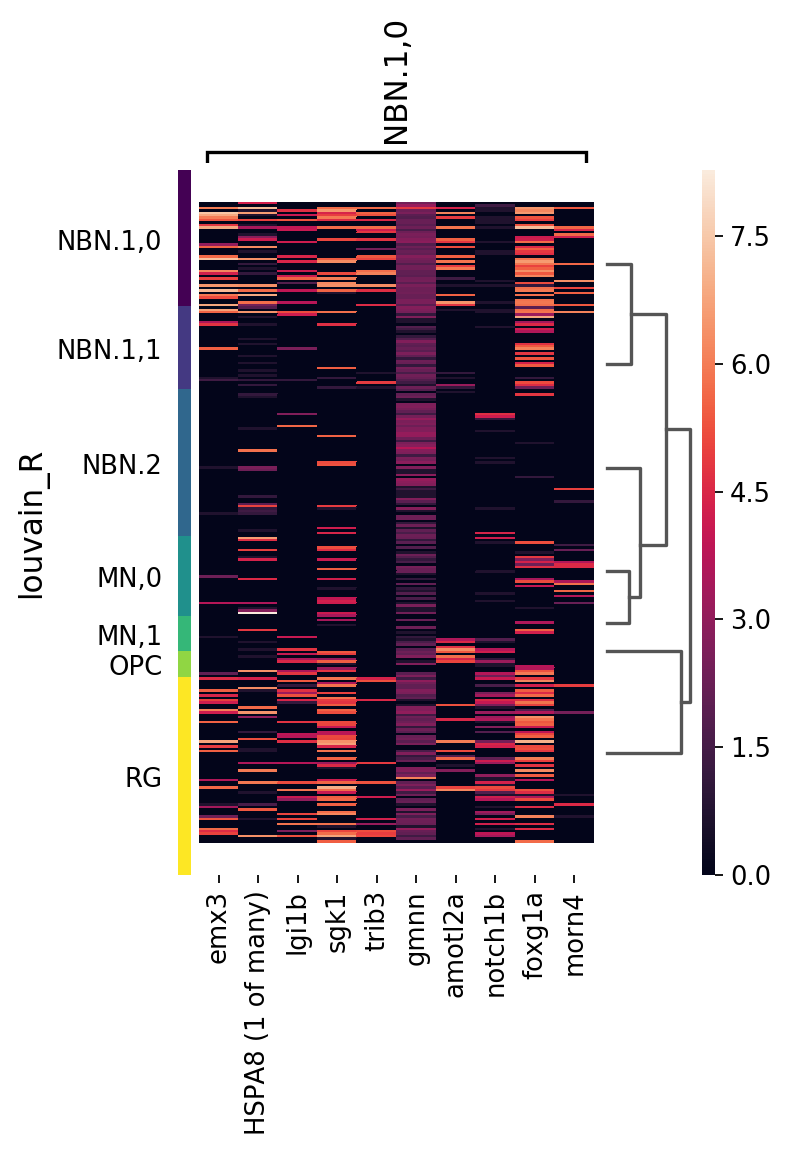

In [71]:
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['NBN.1,0'], key_added='rank_genes_NBN.1,1', reference='NBN.1,1')
sc.tl.rank_genes_groups(adata, 'louvain_R', groups=['NBN.1,1'], key_added='rank_genes_NBN.1,0', reference='NBN.1,0')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_NBN.1,0')
sc.pl.rank_genes_groups_heatmap(adata, key='rank_genes_NBN.1,1')

## Cell numbers

In [72]:
adata.obs.groupby('louvain').size()

louvain
RG       74
NBN.1    82
NBN.2    55
MN       43
OPC      10
dtype: int64

In [73]:
table = adata.obs.groupby(['sort_gate', 'louvain']).size().reset_index().pivot(
    index='sort_gate', columns='louvain', values=0).fillna(0).astype(int)
table

louvain    RG  NBN.1  NBN.2  MN  OPC
sort_gate                           
RG         74      2      0   0    0
NBN         0     78     54  20   10
MN          0      2      1  23    0

In [74]:
robjects.globalenv['tab'] = table.values
print(robjects.r("fisher.test(tab, simulate.p.value=TRUE, B=2000)"))


	Fisher's Exact Test for Count Data with simulated p-value (based on
	2000 replicates)

data:  tab
p-value = 0.0004998
alternative hypothesis: two.sided




# Fig. 2B

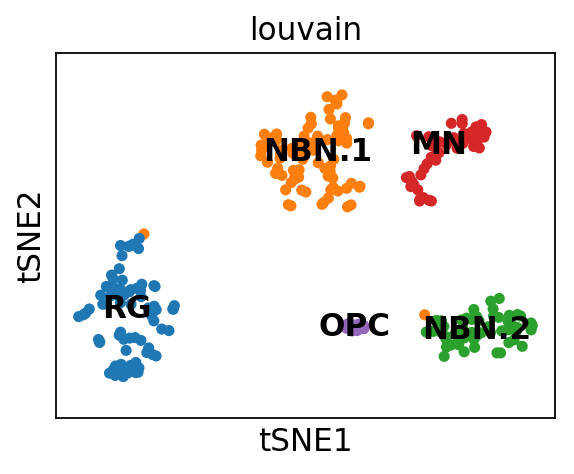

In [75]:
ax = sc.pl.tsne(adata, color=['louvain'],
          legend_loc='on data', size=100, show=False)
fig = plt.gcf()
fig.set_size_inches(4, 3)
ax.set_aspect('equal', adjustable='datalim')
# plt.savefig('../../results/figures/tsne_2Ba.pdf', dpi=300, bbox_inches='tight')
plt.show()

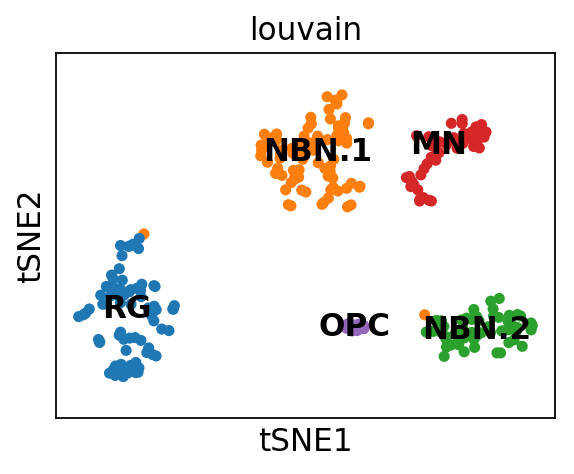

In [76]:
ax = sc.pl.tsne(adata, color=['louvain'],
          legend_loc='on data', size=100, show=False)
fig = plt.gcf()
fig.set_size_inches(4, 3)
ax.set_aspect('equal', adjustable='datalim')
# plt.savefig('../../results/figures/tsne_2Ba.pdf', dpi=300, bbox_inches='tight')
plt.show()

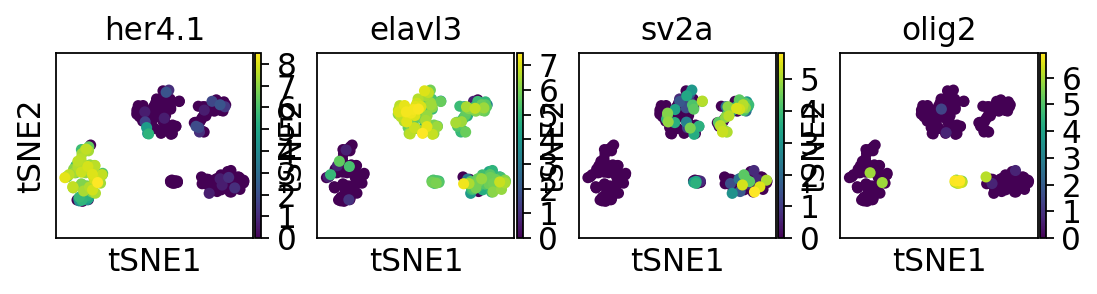

In [77]:
axs = sc.pl.tsne(adata, color=['her4.1', 'elavl3', 'sv2a', 'olig2'],
          legend_loc='on data', size=100, show=False)
for ax in axs:
    ax.set_aspect('equal', adjustable='datalim')
fig = plt.gcf()
fig.set_size_inches(0.5*19.32 * 7.4/8.2 * 0.9, 2*3/4)
# plt.savefig('../../results/figures/tsne_2Bb.pdf', dpi=300, bbox_inches='tight')

# Fig. Supplement tSNE

si:ch211-2111b21.1 (encoding fgfbp3)

In [78]:
markers['RGb'] = ['fabp7a', 'her4.1', 'glula', 'si:ch211-251b21.1', 'zgc:165461', 'atp1a1b',
                  'sepp1a', 'mdka']
markers['NBN.1b'] = ['tubb5', 'cd99l2', 'ppp1r14ba', 'cnp', 'tubb2b']
markers['NBN.2b'] = ['ebf3a', 'si:dkey-106c17.3', 'tbr1b', 'msi2b', 'podxl2']
markers['MNb'] = ['si:ch211-276i12.12', 'pam', 'gad1b', 'sybu', 'ngb']
markers['OPCb'] = ['aplnra', 'sema5a', 'si:ch211-286c4.6', 'traf4a', 'cd82a']

In [79]:
colors = ['sort_gate'] +  markers['RGb'] + markers['NBN.1b'] + markers['NBN.2b'] +\
          markers['MNb'] + markers['OPCb'] 
print(colors)

['sort_gate', 'fabp7a', 'her4.1', 'glula', 'si:ch211-251b21.1', 'zgc:165461', 'atp1a1b', 'sepp1a', 'mdka', 'tubb5', 'cd99l2', 'ppp1r14ba', 'cnp', 'tubb2b', 'ebf3a', 'si:dkey-106c17.3', 'tbr1b', 'msi2b', 'podxl2', 'si:ch211-276i12.12', 'pam', 'gad1b', 'sybu', 'ngb', 'aplnra', 'sema5a', 'si:ch211-286c4.6', 'traf4a', 'cd82a']


In [80]:
# axs = sc.pl.tsne(adata, color=colors, size=100, show=False)

# for ax in axs:
#     ax.set_aspect('equal', adjustable='datalim')
    
# plt.savefig('../../results/figures/tsne_supplement.pdf', dpi=300, bbox_inches='tight')
# plt.show()
# plt.close()

# Fig. Supplement PCA

saving figure to file ./figures/pca_supplement.pdf


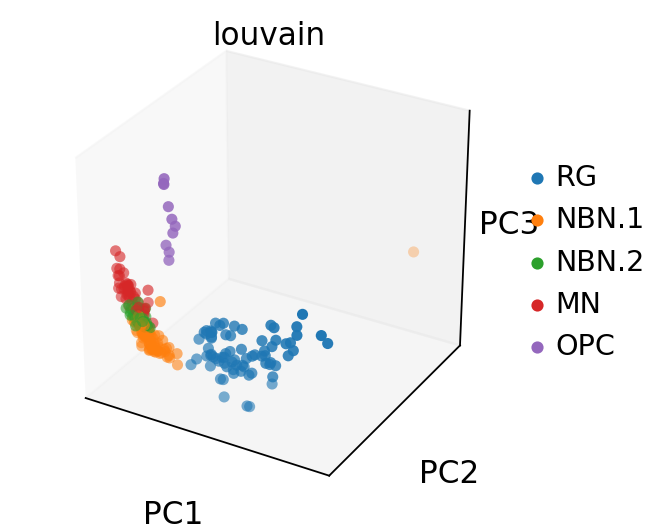

In [81]:
sc.pl.pca(adata, color='louvain', projection='3d', size=100, save='_supplement')

# Fig. Supplement Diffusion Map

saving figure to file ./figures/diffmap_supplement.pdf


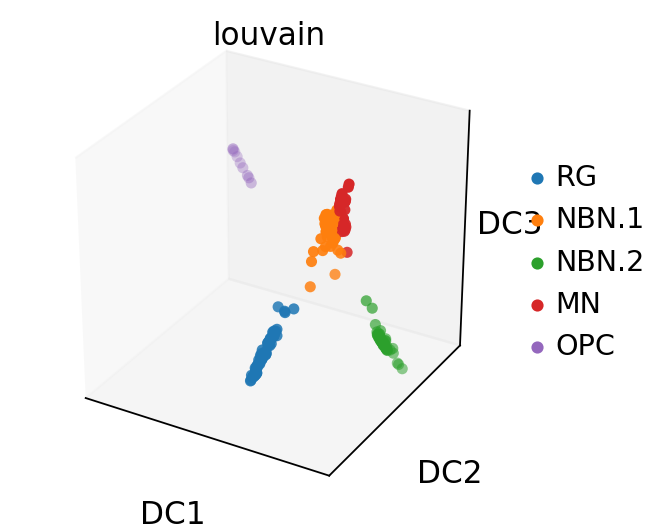

In [82]:
sc.pl.diffmap(adata, color='louvain', projection='3d', save='_supplement', size=100)

# Marker Genes

## Find marker genes

In [83]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg', multi_class='multinomial', solver='lbfgs')

ranking genes
    finished (0:00:02.45) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids



# Fig 2.C

saving figure to file ./figures/heatmap_2C.pdf


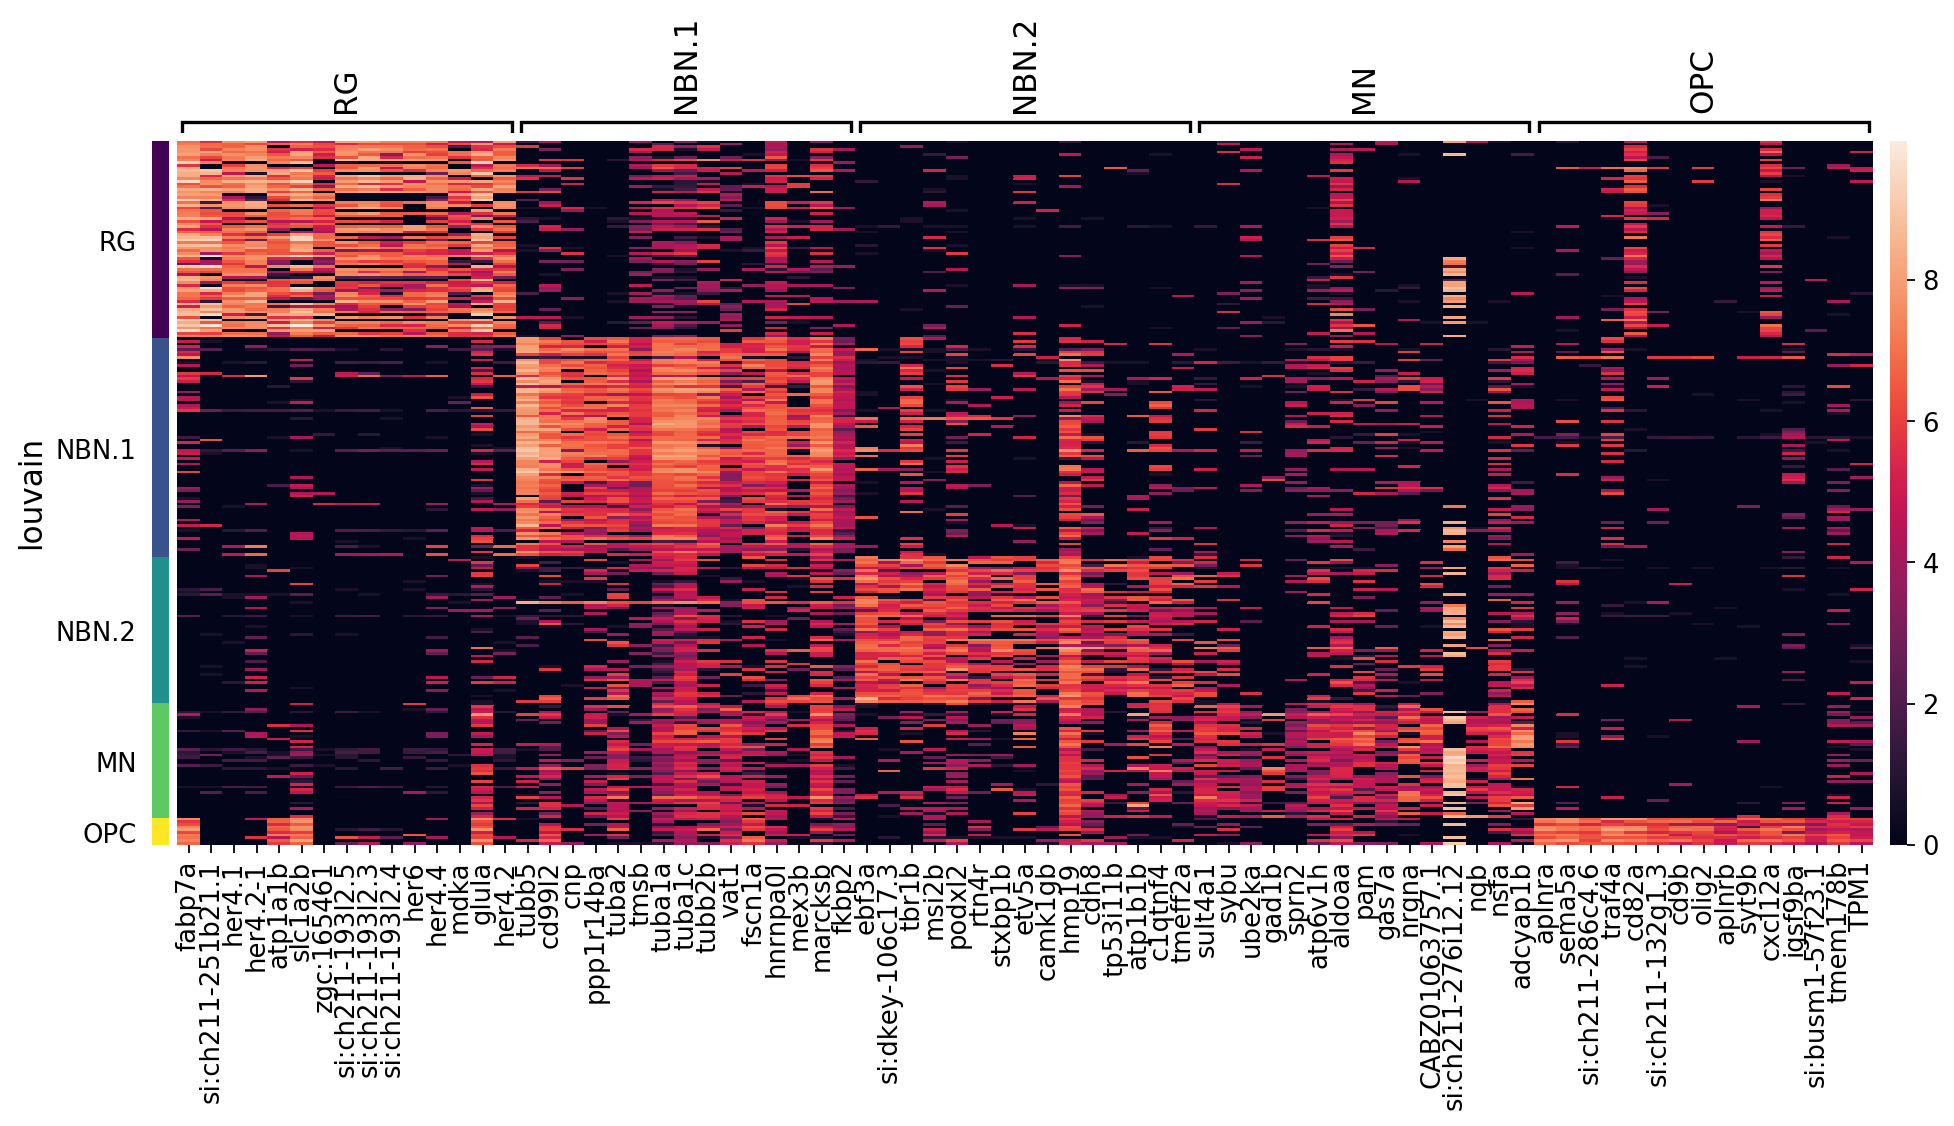

In [84]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=15, dendrogram=False,
                               save='_2C')

In [85]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
adata.uns['DE'] = pd.DataFrame({group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores']})

max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
display(adata.uns['DE'])
pd.set_option('display.max_rows', max_rows)
# adata.uns['DE'].to_excel('../../results/marker_genes.xlsx')

RG_names  RG_scores        NBN.1_names  NBN.1_scores  \
0               fabp7a   0.025682              tubb5      0.031932   
1    si:ch211-251b21.1   0.024557             cd99l2      0.023156   
2               her4.1   0.023605                cnp      0.020521   
3             her4.2-1   0.019606          ppp1r14ba      0.019352   
4              atp1a1b   0.019518              tuba2      0.017813   
5              slc1a2b   0.019294               tmsb      0.015245   
6           zgc:165461   0.019190             tuba1a      0.014916   
7     si:ch211-193l2.5   0.019066             tuba1c      0.014680   
8     si:ch211-193l2.3   0.018981             tubb2b      0.014484   
9     si:ch211-193l2.4   0.018891               vat1      0.014478   
10                her6   0.018578             fscn1a      0.013942   
11              her4.4   0.017763           hnrnpa0l      0.013926   
12                mdka   0.017063              mex3b      0.013652   
13               glula   0.016810            marcksb      0.013641   
14              her4.2   0.016797              fkbp2      0.013618   
15             slc1a3b   0.016458               hn1b      0.013577   
16               s100b   0.016108             kdm6bb      0.013304   
17                cx43   0.015898             mllt11      0.013235   
18             her15.2   0.015844             gpm6ab      0.012882   
19             her15.1   0.015533             rcan1a      0.012866   
20                her9   0.015406             zfpm2a      0.012798   
21              sepp1a   0.014647            dpysl5a      0.012796   
22                 dla   0.013686             tubb4b      0.012744   
23              atp1b4   0.013590  si:ch211-288g17.3      0.012712   
24               fads2   0.013521   si:ch73-281n10.2      0.011968   
25               efhd1   0.013125             elavl3      0.011698   
26              cox4i2   0.012381               rps6      0.011638   
27                lix1   0.012285            nme2b.1      0.011618   
28                 ptn   0.012183                jun      0.011528   
29               s1pr1   0.011630               cct4      0.011523   
30    si:ch211-193l2.6   0.011566                vim      0.011421   
31             zfp36l2   0.011521               syt4      0.011333   
32               cd82a   0.011422              actb1      0.011156   
33               grm2b   0.011329              rtn1b      0.011099   
34                mdkb   0.011210             stmn2a      0.011048   
35               ccnd1   0.010913              RPS17      0.010997   
36              ppap2d   0.010759         zgc:153426      0.010973   
37              her4.3   0.010701           hist2h2l      0.010808   
38                 boc   0.010284             fmnl2b      0.010775   
39            cyp19a1b   0.009963               cct5      0.010712   
40               gstp1   0.009935             stmn1b      0.010648   
41               dap1b   0.009934            neurod1      0.010635   
42             cxcl12a   0.009899              CRIP2      0.010618   
43              nell2a   0.009832                erh      0.010602   
44               luzp2   0.009680  si:ch211-195b15.8      0.010459   
45                her2   0.009646         zgc:162707      0.010398   
46              sox19a   0.009342              rps3a      0.010390   
47             dap1b-1   0.009332             ahsa1b      0.010384   
48                 id1   0.009325             hspa4a      0.010347   
49                lfng   0.009317              zc4h2      0.010345   
50          zgc:153704   0.009278              kdm1a      0.010128   
51               glulb   0.009169               ybx1      0.010063   
52              sdcbp2   0.009063             sumo2b      0.009860   
53    si:ch211-286b5.5   0.009060            slc38a2      0.009832   
54              mfge8a   0.008996  si:ch211-194k22.8      0.009824   
55  si:ch1073-303k11.2   0.008946             tuba1b      0.009785   
56                sox3  

# Export adata object

In [86]:
adata.layers['counts'] = adata_original[adata.obs_names][:,adata.var_names].X

In [87]:
# adata.write('../../results/zebrabrain.h5ad')

# Drop OPCs

In [88]:
adata2 = adata[adata.obs['louvain'] != 'OPC'].copy()

In [89]:
adata2.uns['louvain_colors'] = [tuple(color) for color in adata2.uns['louvain_colors']]

## PCA

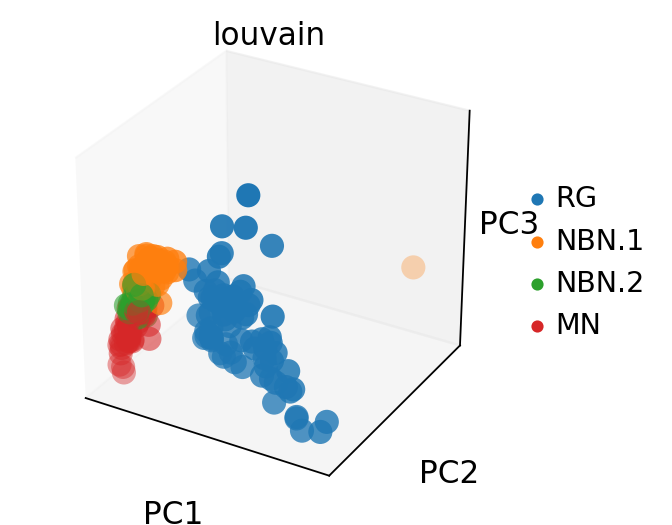

In [90]:
sc.tl.pca(adata2, svd_solver='arpack')
sc.pl.pca(adata2, color='louvain', projection='3d')

## tsne

computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:00.71) --> added
    'X_tsne', tSNE coordinates (adata.obsm)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:00.63) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


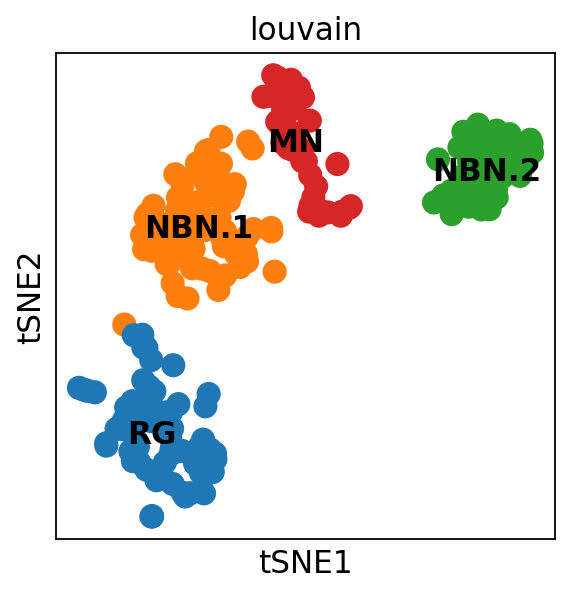

In [91]:
sc.tl.tsne(adata2, n_jobs=10, n_pcs=10, random_state=15, perplexity=40)
sc.tl.tsne(adata2, n_jobs=10, n_pcs=10, random_state=15, perplexity=40)
sc.pl.tsne(adata2, color='louvain', legend_loc='on data')

## UMAP

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00.08) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:00.50) --> added
    'X_umap', UMAP coordinates (adata.obsm)


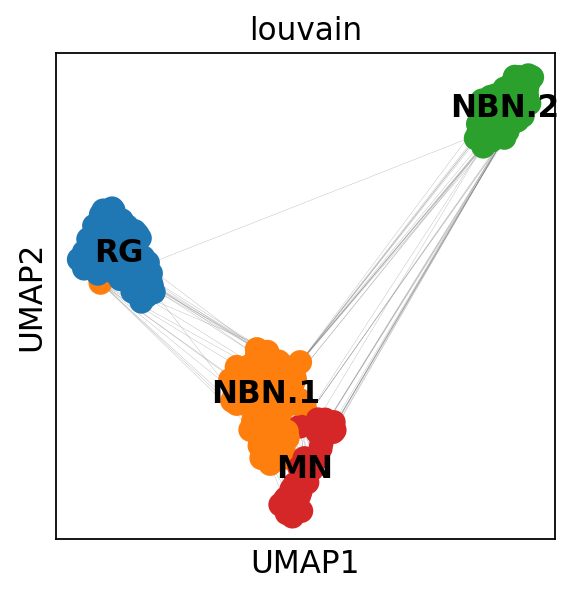

In [92]:
sc.pp.neighbors(adata2, n_neighbors=15, n_pcs=10)
sc.tl.umap(adata2, random_state=42)
sc.pl.umap(adata2, color='louvain', legend_loc='on data', edges=True)

# DiffusionMap & DPT

In [93]:
# sc.pp.neighbors(adata, n_neighbors=200, n_pcs=10)
sc.pp.neighbors(adata2, method='gauss', knn=False, n_neighbors=5, n_pcs=10, random_state=42)
sc.tl.diffmap(adata2, n_comps=10)
# adata2.uns['iroot'] = adata2.obsm['X_diffmap'][:,1].argmin()

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:00.02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing Diffusion Maps using n_comps=10(=n_dcs)
    eigenvalues of transition matrix
    [1.0000001  0.9896776  0.9852548  0.97441155 0.96880364 0.9475976
     0.9241232  0.91859835 0.91042817 0.9016294 ]
    finished (0:00:00.02) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)


/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [94]:
adata2.uns['iroot'] = np.flatnonzero(adata2.obs['louvain'] == 'RG')[-1]
print(f"root cell: {adata2.obs.iloc[np.flatnonzero(adata2.obs['louvain'] == 'RG')[-1]]['sample_id']}")
# adata2.uns['iroot'] = adata2.obsm['X_diffmap'][:,1].argmin()
sc.tl.dpt(adata2, n_branchings=1)

root cell: RG-5_03_D09
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.10) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)
    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


In [95]:
mpl.rcParams['axes3d.grid'] = False
mpl.rcParams['axes3d.grid'] = False

In [96]:
adata2.uns['iroot']

233

In [97]:
r = np.zeros(254)
r[233] = 1

In [98]:
adata2.obs['root'] = r

# Fig. 3A,B

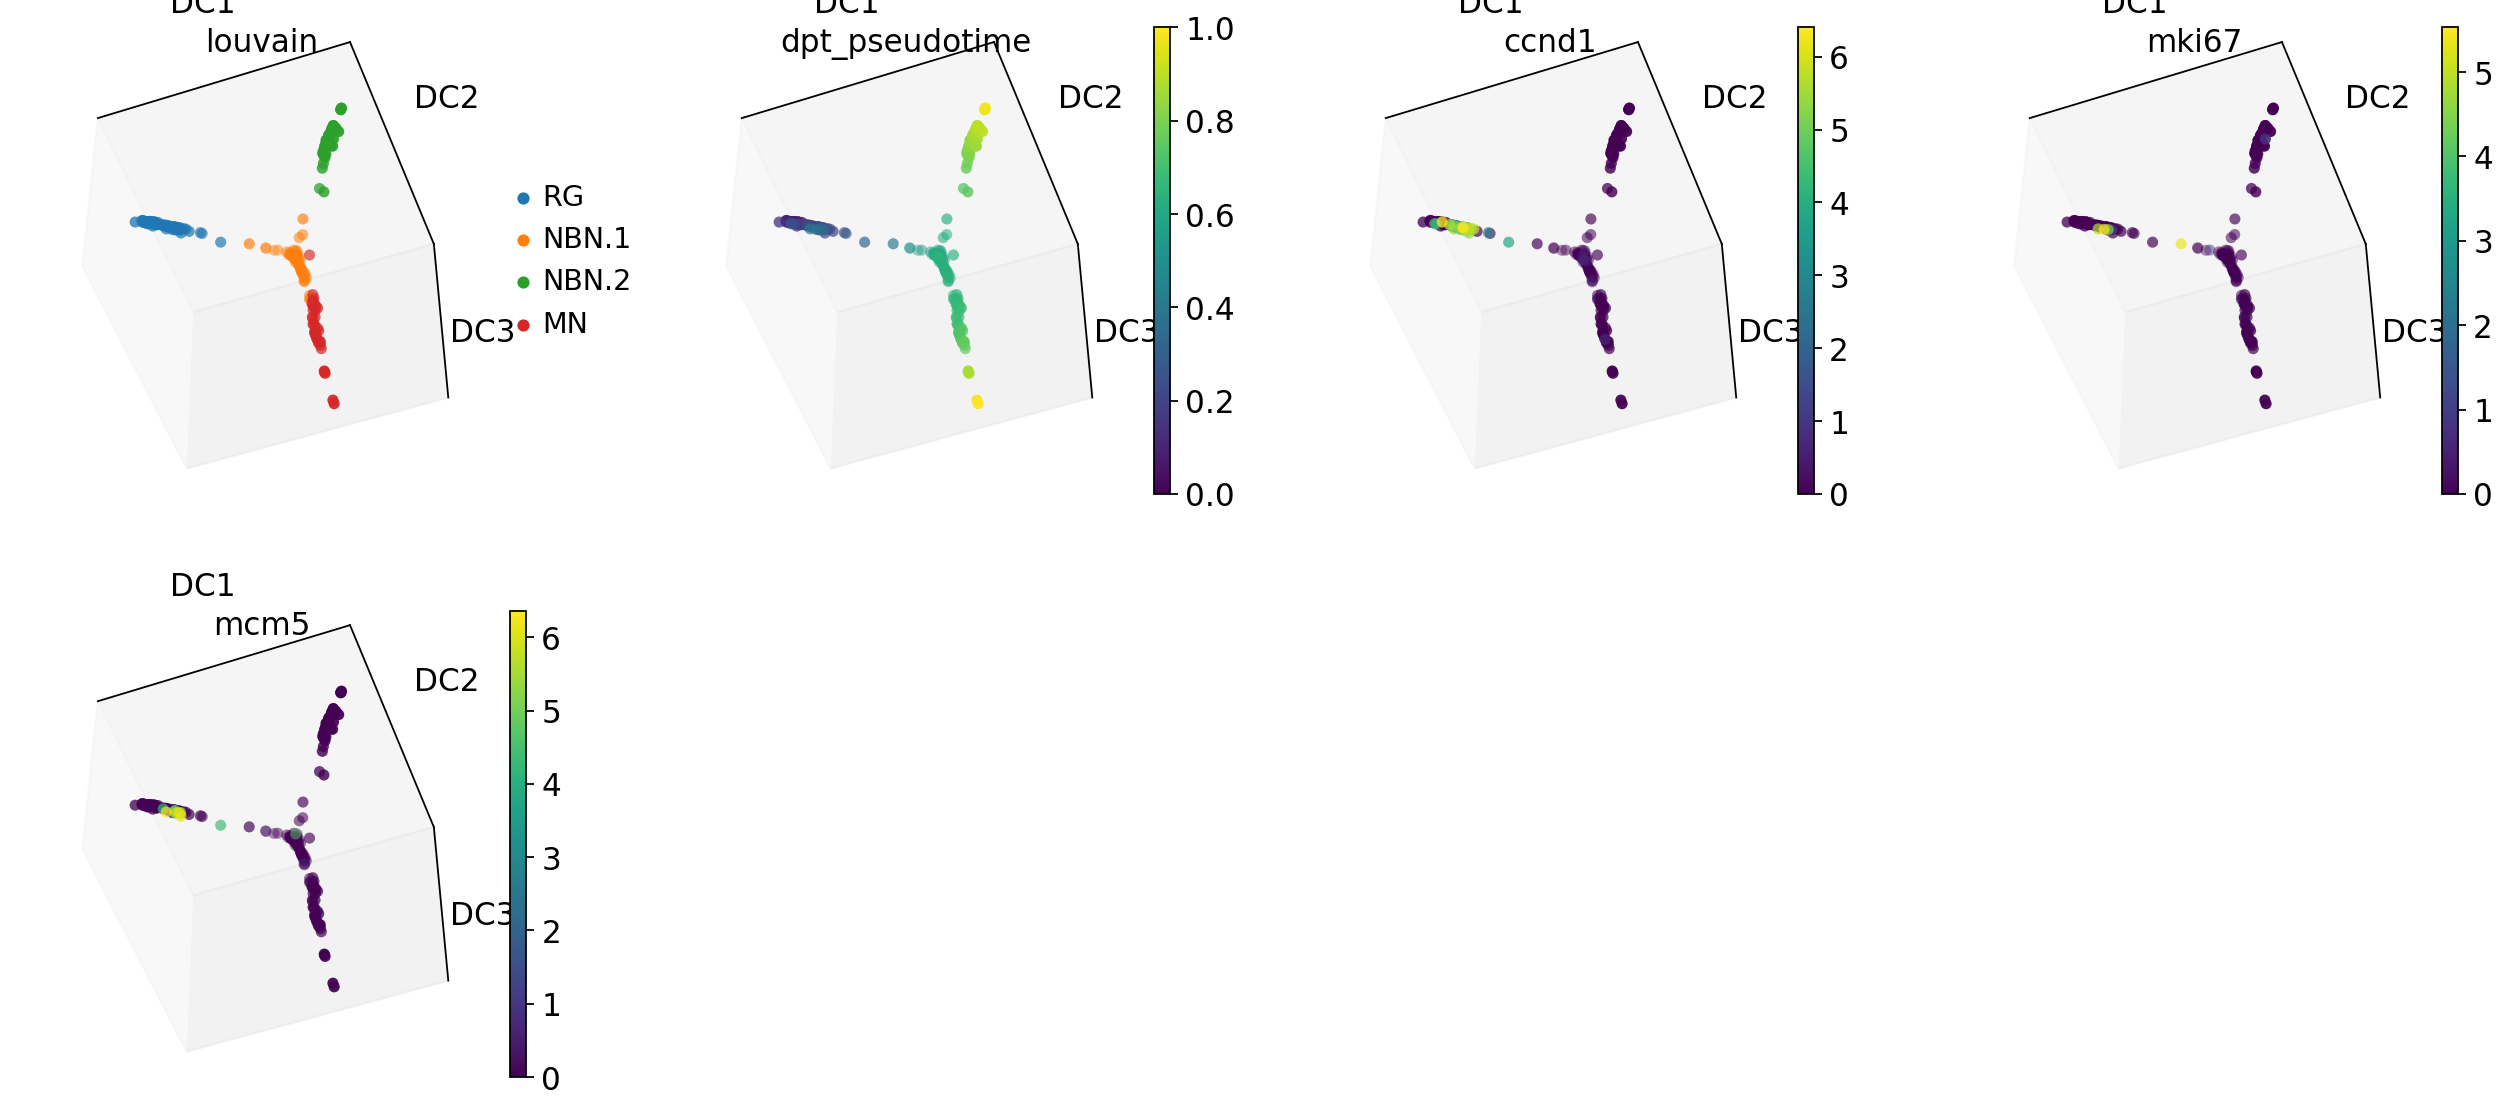

In [99]:
axs = sc.pl.diffmap(adata2, color=['louvain', 'dpt_pseudotime'] + markers['proliferation'],
                         projection='3d', show=False, frameon=True, size=100)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
# plt.savefig('../../results/figures/diffmap_3AB.pdf', dpi=300, bbox_inches='tight')
plt.show()
# plt.close()

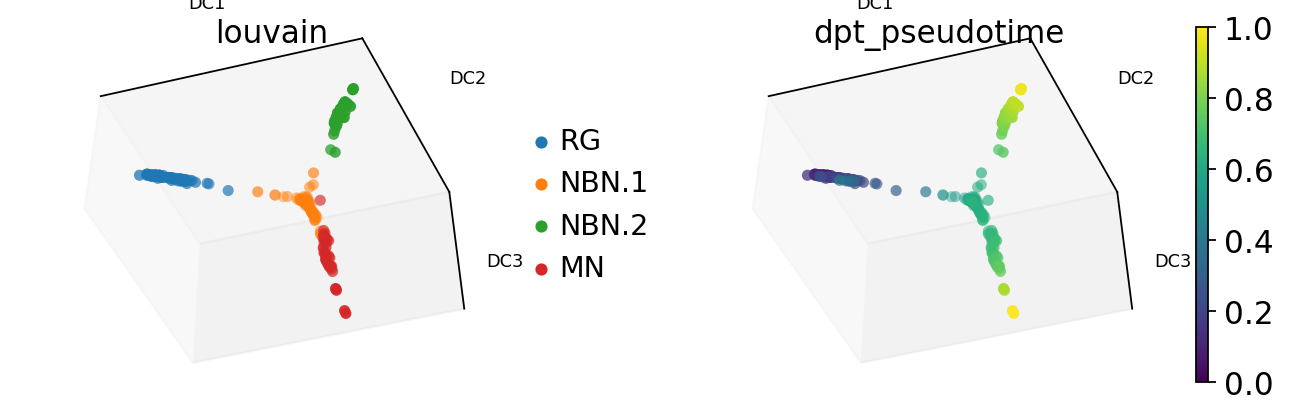

In [100]:
axs = sc.pl.diffmap(adata2, color=['louvain', 'dpt_pseudotime'],
                         projection='3d', show=False, frameon=True, size=100)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(1.2*8, 1.2*2.4)
# plt.savefig('../../results/figures/diffmap_3A.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

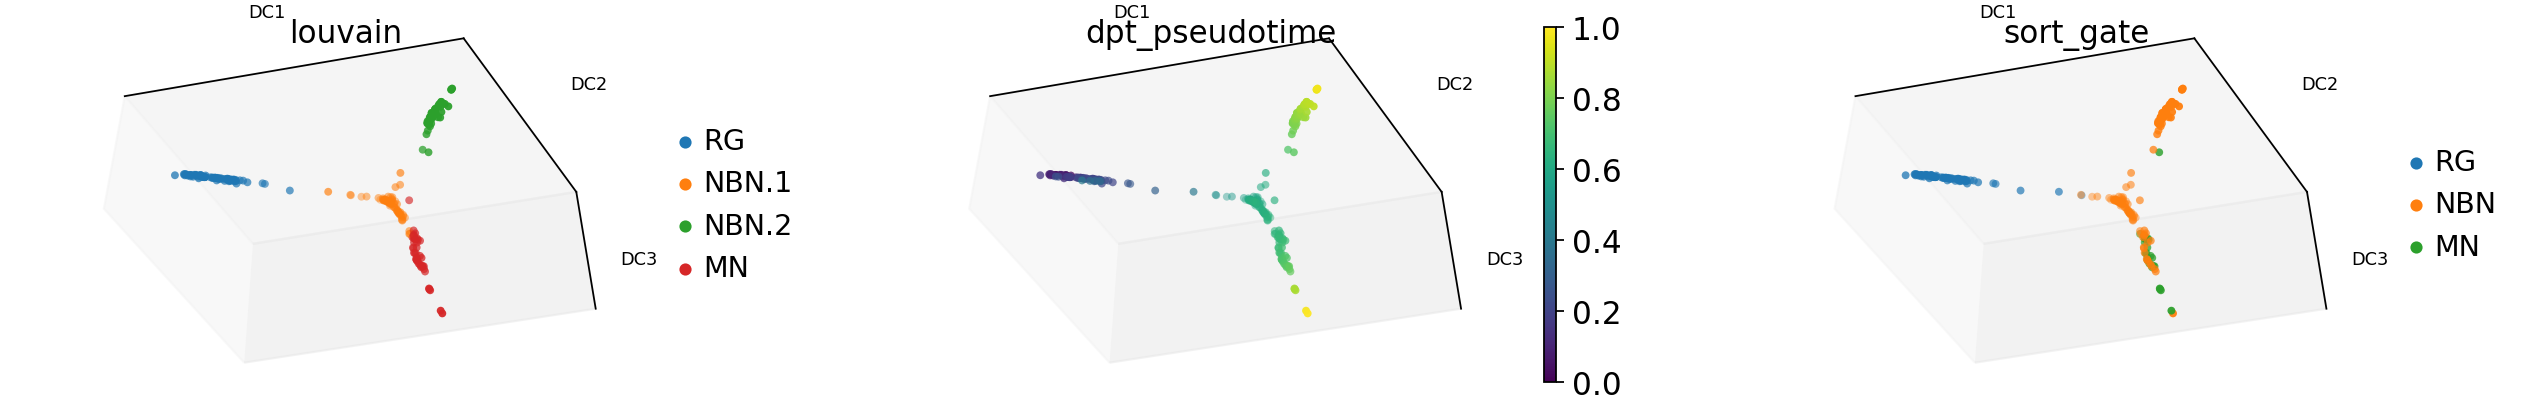

In [101]:
axs = sc.pl.diffmap(adata2, color=['louvain', 'dpt_pseudotime', 'sort_gate'],
                         projection='3d', show=False, frameon=True, size=50)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(2*1.2*8, 1.2*2.4)
# plt.savefig('../../results/figures/diffmap_3A.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

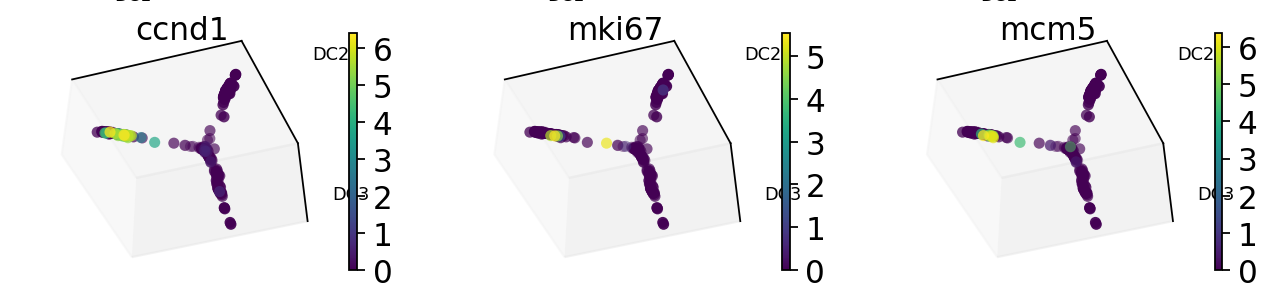

In [102]:
axs = sc.pl.diffmap(adata2, color=markers['proliferation'],
                         projection='3d', show=False, frameon=True, size=100)
for ax in axs:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(1.2*8, 1.2*2.4*2/3)
# plt.savefig('../../results/figures/diffmap_3B.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

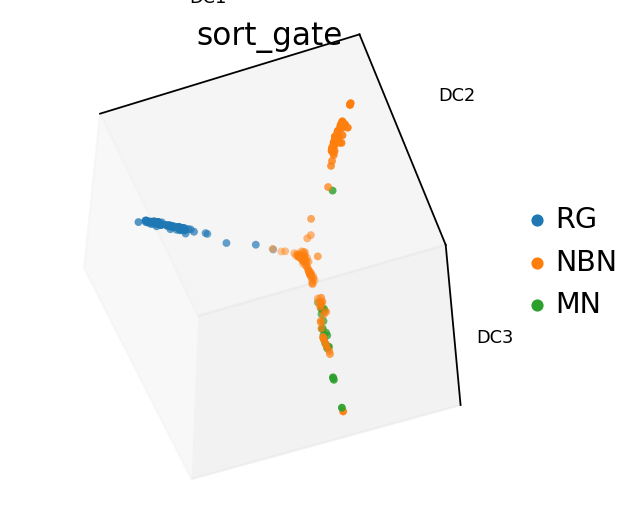

In [103]:
axs = sc.pl.diffmap(adata2, color=['sort_gate'],
                         projection='3d', show=False, size=50)
for ax in [axs]:
    ax.view_init(elev=125, azim=-110)
    ax.set_xlabel('DC1', fontsize=8)
    ax.set_ylabel('DC2', fontsize=8)
    ax.set_zlabel('DC3', fontsize=8)
# fig = plt.gcf()
# fig.set_size_inches(1.2*8, 1.2*2.4*2/3)
# plt.savefig('../../results/figures/diffmap_3B.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Fig 3C

Needs to be rotated using Illustrator

saving figure to file ./figures/heatmap_3B.pdf


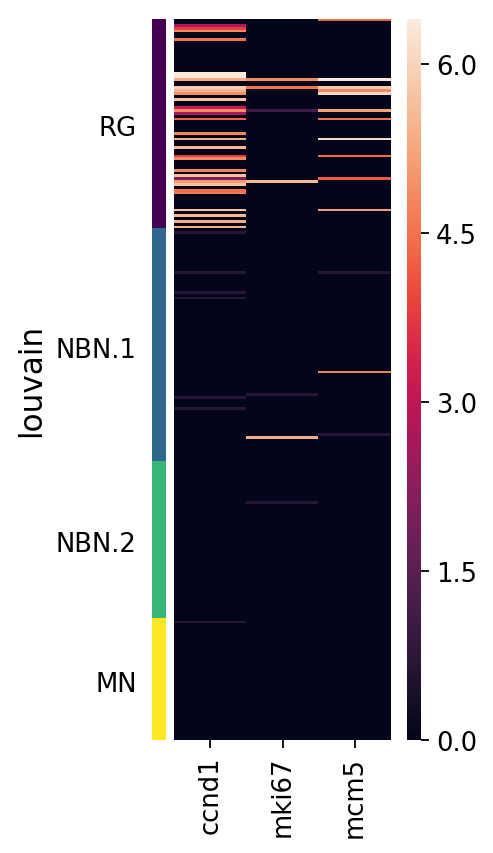

In [104]:
sc.pl.heatmap(adata2, var_names=['ccnd1', 'mki67', 'mcm5'], groupby='louvain', show=True, save='_3B')

# DEA proliferative RGS

## Based on ccnd1

In [105]:
adata_RG = adata2[adata2.obs['louvain'] == 'RG']
del adata_RG.uns['iroot']

In [106]:
adata_RG.obs['prol_ccnd1'] = pd.Series(
    adata_RG.raw[:, 'ccnd1'].X > 0
    ).astype('category').cat.rename_categories({False: 'ccnd1-', True: 'ccnd1+'}).values

In [107]:
sc.tl.rank_genes_groups(adata_RG, 'prol_ccnd1', method='wilcoxon', key_added='rank_genes_ccnd1',
                       use_raw=True)

ranking genes
    finished (0:00:00.22) --> added to `.uns['rank_genes_ccnd1']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


saving figure to file ./figures/heatmap_3C.pdf


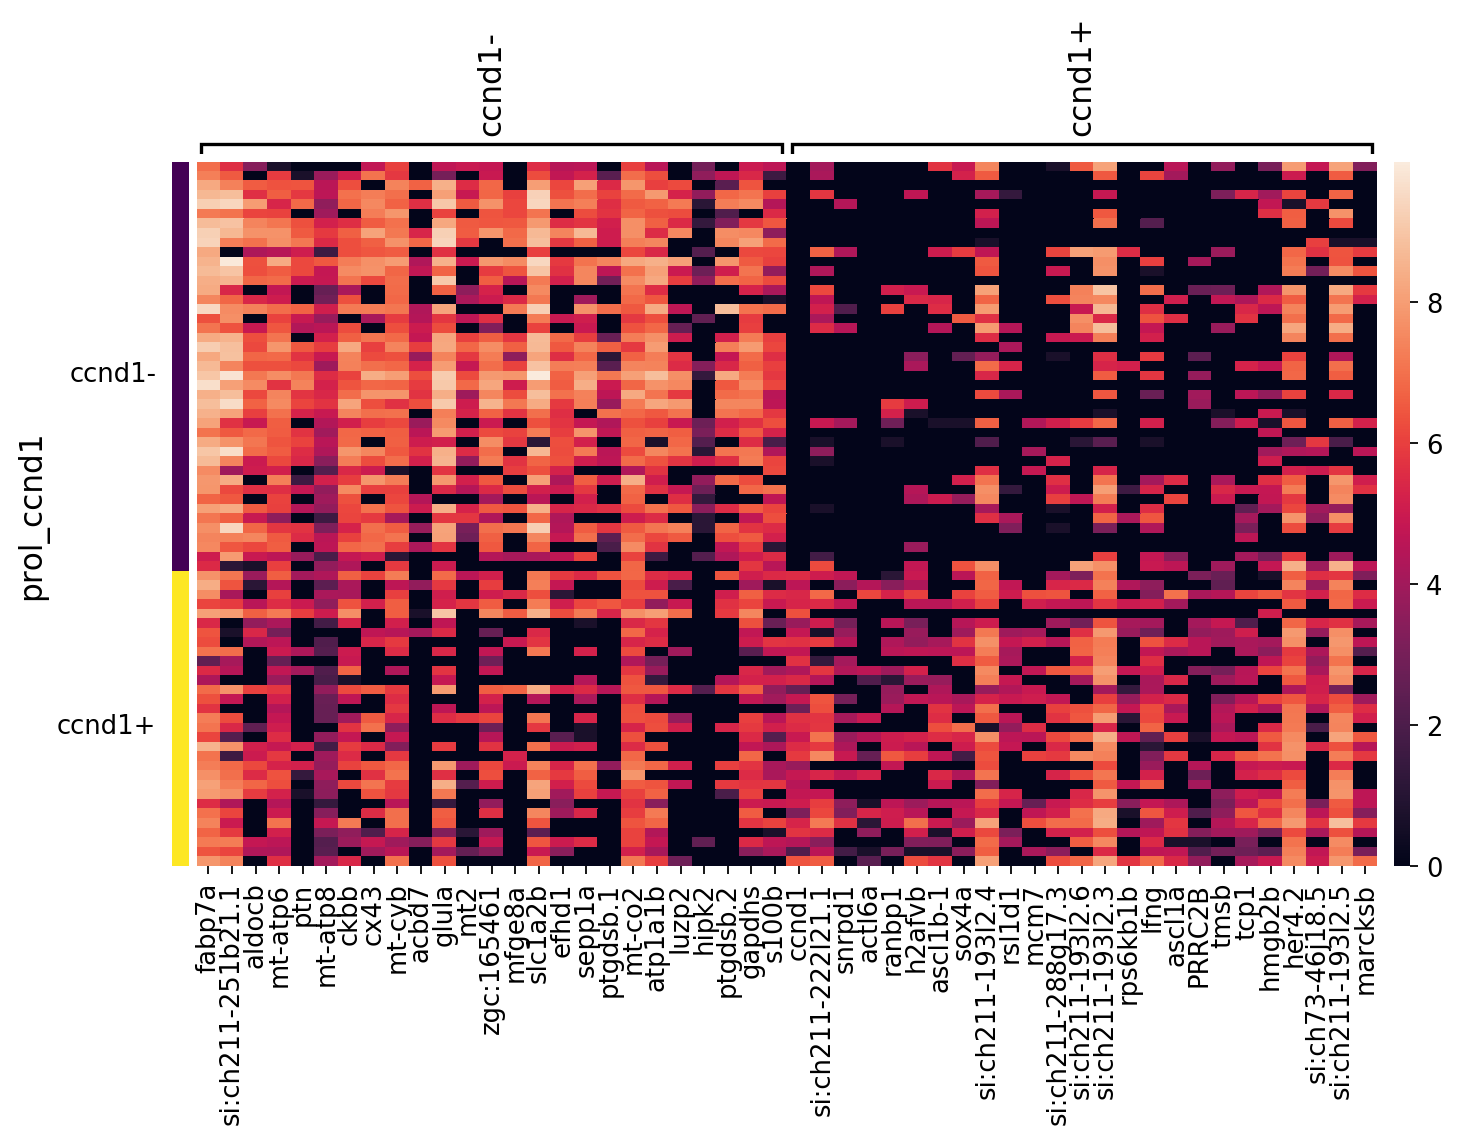

<Figure size 320x320 with 0 Axes>

In [108]:
ax = sc.pl.rank_genes_groups_heatmap(adata_RG, n_genes=25, key='rank_genes_ccnd1', 
                                dendrogram=False, save='_3C', use_raw=True, show=True)
fig=plt.gcf()
# fig.get_size_inches()
# fig.set_size_inches(1.2*3.4, 1.2*1.1)

In [109]:
result = adata_RG.uns['rank_genes_ccnd1']
groups = result['names'].dtype.names
adata_RG.uns['DE'] = pd.DataFrame({group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'scores','pvals','pvals_adj', 'logfoldchanges']})

max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
display(adata_RG.uns['DE'])
pd.set_option('display.max_rows', max_rows)
# adata_RG.uns['DE'].to_excel('../../results/marker_genes_proliferative_RG.xlsx')

ccnd1-_names  ccnd1-_scores  ccnd1-_pvals  ccnd1-_pvals_adj  \
0              fabp7a       4.519276      0.000006          0.066738   
1   si:ch211-251b21.1       4.420674      0.000010          0.073889   
2              aldocb       4.387806      0.000011          0.073889   
3             mt-atp6       4.327549      0.000015          0.078671   
4                 ptn       4.300159      0.000017          0.078671   
5             mt-atp8       4.163212      0.000031          0.126564   
6                ckbb       4.091999      0.000043          0.134645   
7                cx43       4.091999      0.000043          0.134645   
8              mt-cyb       4.075565      0.000046          0.134645   
9               acbd7       4.009830      0.000061          0.150812   
10              glula       3.850971      0.000118          0.271151   
11                mt2       3.823581      0.000132          0.282924   
12         zgc:165461       3.681156      0.000232          0.463235   
13             mfge8a       3.659244      0.000253          0.463235   
14            slc1a2b       3.653766      0.000258          0.463235   
15              efhd1       3.637332      0.000275          0.467817   
16             sepp1a       3.593509      0.000326          0.522789   
17           ptgdsb.1       3.582553      0.000340          0.522789   
18             mt-co2       3.549686      0.000386          0.565668   
19            atp1a1b       3.489429      0.000484          0.650843   
20              luzp2       3.483951      0.000494          0.650843   
21              hipk2       3.478473      0.000504          0.650843   
22           ptgdsb.2       3.445606      0.000570          0.707099   
23             gapdhs       3.434650      0.000593          0.709039   
24              s100b       3.418216      0.000630          0.726366   
25             mt-co3       3.368915      0.000755          0.811648   
26            slc4a4a       3.336047      0.000850          0.884491   
27             sdcbp2       3.325092      0.000884          0.891242   
28           slc6a11b       3.308658      0.000937          0.916339   
29         zgc:153704       3.237445      0.001206          1.000000   
30               tegt       3.204577      0.001353          1.000000   
31               psap       3.122409      0.001794          1.000000   
32              s1pr1       3.095019      0.001968          1.000000   
33            lgals2a       3.040240      0.002364          1.000000   
34               gmnn       3.034762      0.002407          1.000000   
35               b2ml       2.990939      0.002781          1.000000   
36           hepacama       2.963550      0.003041          1.000000   
37             mt-nd1       2.936160      0.003323          1.000000   
38               mgll       2.925204      0.003442          1.000000   
39             atp1b4       2.914248      0.003565          1.000000   
40            anxa11b       2.886859      0.003891          1.000000   
41             ndrg3a       2.886859      0.003891          1.000000   
42             itm2ba       2.853991      0.004317          1.000000   
43             ppap2d       2.826602      0.004704          1.000000   
44             mt-nd2       2.777301      0.005481          1.000000   
45            cxcl12a       2.771823      0.005574          1.000000   
46              grm2b       2.738955      0.006163          1.000000   
47           cyp19a1b       2.700610      0.006921          1.000000   
48             sh3bp2       2.667742      0.007636          1.000000   
49             anxa13       2.651309      0.008018          1.000000   
50            swap70b       2.612963      0.008976          1.000000   
51              gstp1       2.596529      0.009417          1.000000   
52     si:dkey-85k7.7       2.536273      0.011204          1.000000   
53              igf2b       2.519839      0.011741          1.000000   
54            pcdh2g5       2.492449      0.01268

### Overlap

Genes that are upregulated in ccnd1+ and are marker genes of NBN.1:

In [110]:
overlap_genes = list(adata_RG.uns['DE']['ccnd1+_names'][
    adata_RG.uns['DE']['ccnd1+_names'].isin(pd.Series(adata.uns['rank_genes_groups']['names']['NBN.1']))
])

In [111]:
s = ''
for gene in overlap_genes:
    s += gene
    s += ', '
print(s)

si:ch211-222l21.1, si:ch211-288g17.3, tmsb, marcksb, cct4, stmn1b, sumo2b, rps6, tuba1c, 


## Fig. Venn

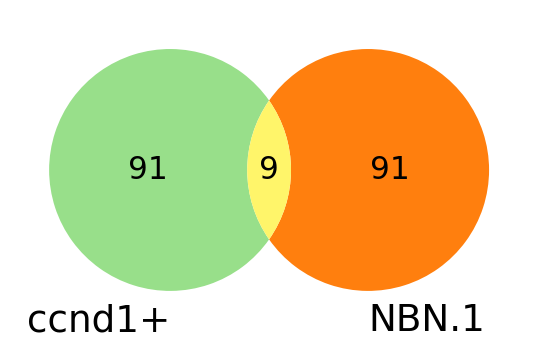

In [112]:
matplotlib_venn.venn2([set(adata_RG.uns['DE']['ccnd1+_names']), set(adata.uns['rank_genes_groups']['names']['NBN.1'])],
                     set_labels=['ccnd1+', 'NBN.1'],
                     set_colors=['#98df8a', (1.0, 0.4980392156862745, 0.054901960784313725)],
                     alpha=1)
# plt.savefig('../../results/figures/venn_ccnd1pos_NBN1.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

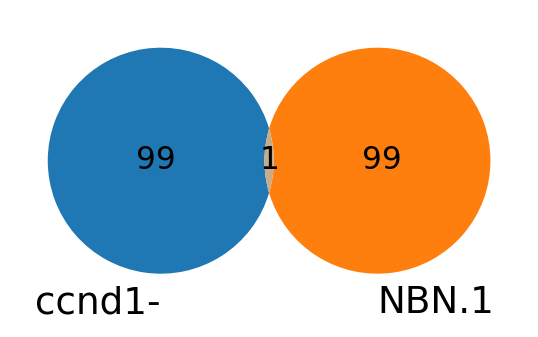

In [113]:
matplotlib_venn.venn2([set(adata_RG.uns['DE']['ccnd1-_names']), set(adata.uns['rank_genes_groups']['names']['NBN.1'])],
                     set_labels=['ccnd1-', 'NBN.1'],
                     set_colors=[(0.1215686275, 0.4666666667, 0.7058823529), 
                                 (1.0, 0.4980392156862745, 0.054901960784313725)],
                     alpha=1)
# plt.savefig('../../results/figures/venn_ccnd1neg_NBN1.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

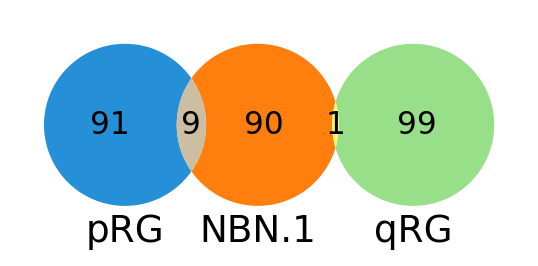

In [114]:
matplotlib_venn.venn3([set(adata_RG.uns['DE']['ccnd1-_names']),
                       set(adata.uns['rank_genes_groups']['names']['NBN.1']),
                      set(adata_RG.uns['DE']['ccnd1+_names'])],
                     set_labels=['qRG', 'NBN.1', 'pRG'],
                     set_colors=['#98df8a',
                         (1.0, 0.4980392156862745, 0.054901960784313725),
                         1.2*np.array([0.1215686275, 0.4666666667, 0.7058823529]) 
                                 ],
                     alpha=1)
# plt.savefig('../../results/figures/venn_pRG_NBN1_qRG.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

## Fig. 3D

In [115]:
# neuro_genes = list(np.array(overlap_genes)[[1, 3, 4, 7, 10]])
neuro_genes = ['ascl1a', 'sox4a', 'tmsb', 'stmn1b']

In [116]:
adata_RG.obs['n_neuro_genes'] = (adata_RG.raw[:, neuro_genes].X > 0).sum(axis=1)
# hist_prol = (adata_RG.raw[adata_RG.obs['prol_ccnd1'] == 'ccnd1+', :][:, neuro_genes].X > 0).sum(axis=1)

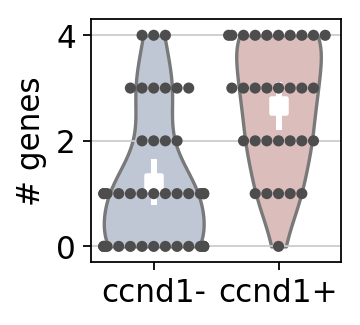

In [117]:
plt.figure(figsize=(2,2))

sns.violinplot(data=adata_RG.obs, x='prol_ccnd1', y='n_neuro_genes', cut=0, inner=None,
              palette='vlag')
sns.swarmplot(data=adata_RG.obs, x='prol_ccnd1', y='n_neuro_genes', color="0.3")
sns.pointplot(data=adata_RG.obs, x='prol_ccnd1', y='n_neuro_genes', linestyles='None', 
              color='1', markers='s')
plt.xlabel('')
plt.ylabel('# genes')
# plt.savefig('../../results/figures/violin_3D.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [118]:
average = adata_RG.obs[['prol_ccnd1', 'n_neuro_genes']].groupby('prol_ccnd1').agg(['mean', 'median'])
average

n_neuro_genes       
                    mean median
prol_ccnd1                     
ccnd1-          1.209302      1
ccnd1+          2.677419      3

### mannwhitneyu

In [119]:
sp.stats.mannwhitneyu(adata_RG.obs.query('prol_ccnd1 == "ccnd1-"')['n_neuro_genes'].values,
                        adata_RG.obs.query('prol_ccnd1 == "ccnd1+"')['n_neuro_genes'].values,
                     alternative='less', use_continuity=False)

MannwhitneyuResult(statistic=275.0, pvalue=5.73011741756029e-06)

### Robustness against ccnd1+ threshold level

In [120]:
sc.settings.verbosity = 0
for threshold in [1, 3, 5, 10, 50, 100, 200, 250]:
    adata_RG.obs[f'prol_ccnd1_{threshold}'] = pd.Series(
        adata_RG.raw[:, 'ccnd1'].X > np.log1p(threshold-1)
        ).astype('category').cat.rename_categories({False: 'ccnd1-', True: 'ccnd1+'}).values
    sc.tl.rank_genes_groups(adata_RG, f'prol_ccnd1_{threshold}', method='wilcoxon', key_added=f'rank_genes_ccnd1_{threshold}',
                           use_raw=True)
    print(threshold)
    n_genes = 25
    f1 = np.isin(adata_RG.uns[f'rank_genes_ccnd1_{threshold}']['names']['ccnd1-'][:n_genes],
                 adata_RG.uns[f'rank_genes_ccnd1']['names']['ccnd1-'][:n_genes]).mean()
    f2 = np.isin(adata_RG.uns[f'rank_genes_ccnd1_{threshold}']['names']['ccnd1+'][:n_genes], 
                 adata_RG.uns[f'rank_genes_ccnd1']['names']['ccnd1+'][:n_genes]).mean()
    print(f'{100*np.mean([f1, f2])}% overlap in top 100 marker genes')
    print(sp.stats.mannwhitneyu(adata_RG.obs.query(f'prol_ccnd1_{threshold} == "ccnd1-"')['n_neuro_genes'].values,
                        adata_RG.obs.query(f'prol_ccnd1_{threshold} == "ccnd1+"')['n_neuro_genes'].values,
                     alternative='less', use_continuity=False))

1
100.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=275.0, pvalue=5.73011741756029e-06)
3
100.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=275.0, pvalue=5.73011741756029e-06)
5
100.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=275.0, pvalue=5.73011741756029e-06)
10
86.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=299.0, pvalue=2.3947750359455014e-05)
50
78.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=295.0, pvalue=0.00010288634310715733)
100
70.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=253.0, pvalue=5.6896283339240435e-05)
200
40.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=210.0, pvalue=0.0015145431731379358)
250
18.0% overlap in top 100 marker genes
MannwhitneyuResult(statistic=158.0, pvalue=0.029542640767987245)


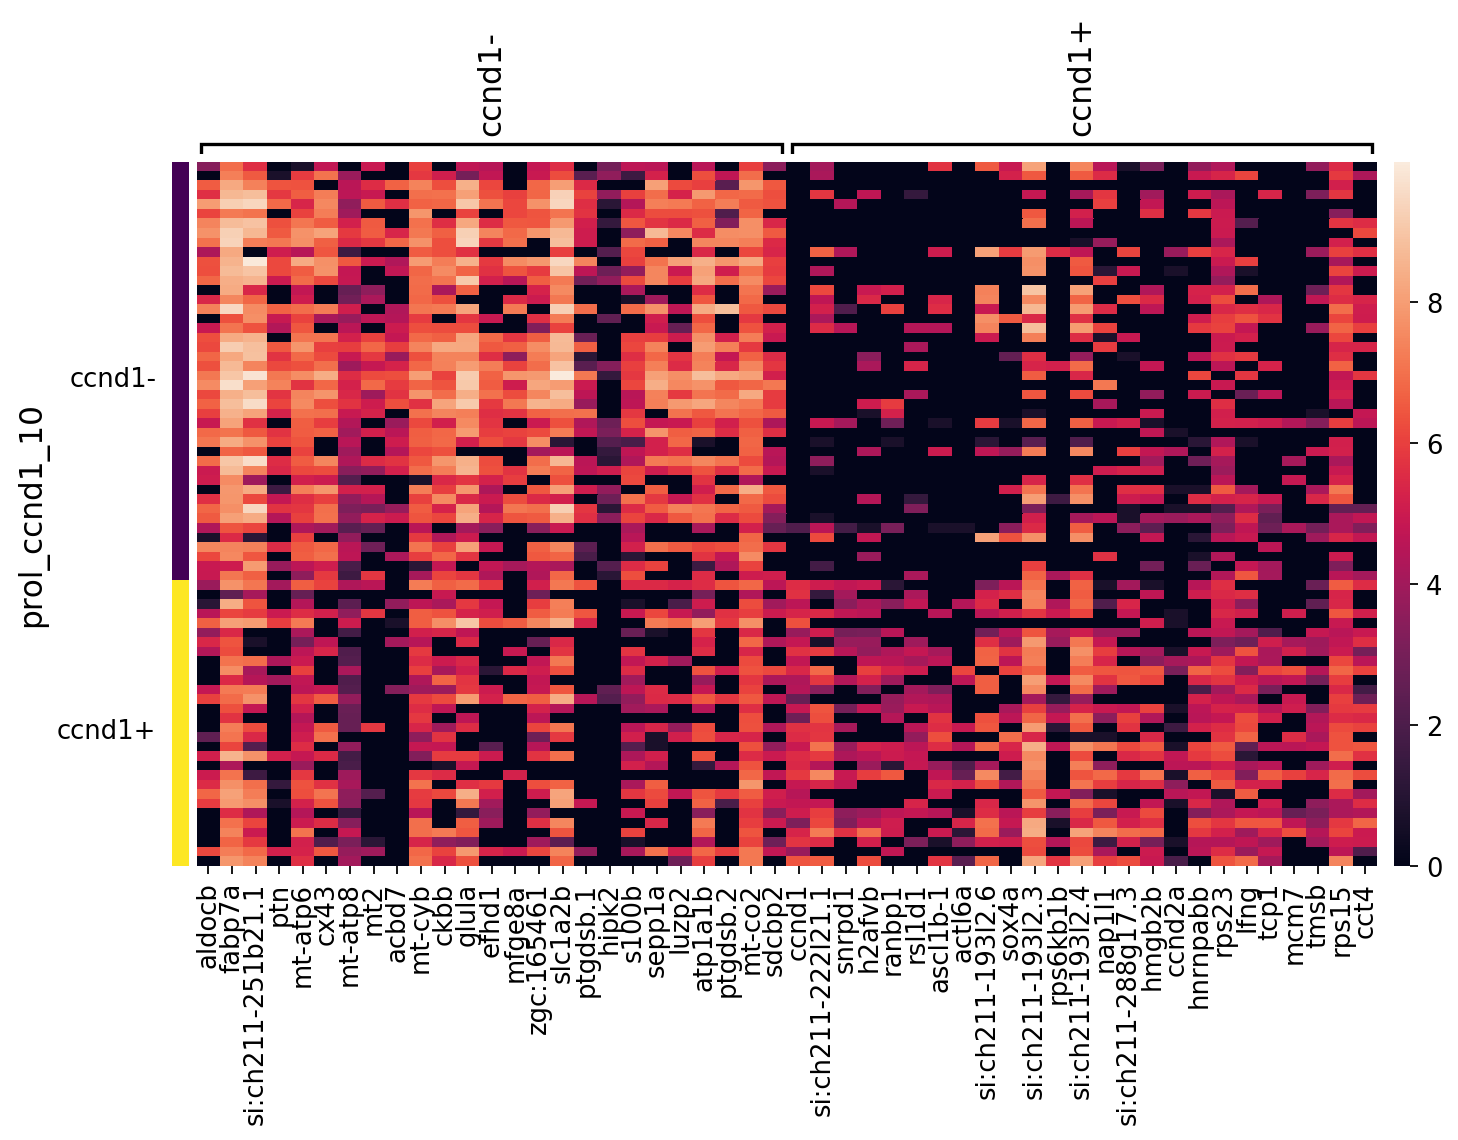

In [121]:
sc.pl.rank_genes_groups_heatmap(adata_RG, key=f'rank_genes_ccnd1_10', n_genes=25, dendrogram=False)

## Hypergeometric test

### ccnd1+ and NBN1

In [122]:
k = len(
    set(
        adata_RG.uns['DE']['ccnd1+_names']
    ).intersection(set(adata.uns['rank_genes_groups']['names']['NBN.1'])))
k

9

In [123]:
p=sp.stats.hypergeom.sf(k-1, 
                        adata_RG.n_vars, 
                        len(adata.uns['rank_genes_groups']['names']['NBN.1']), 
                        len(adata_RG.uns['DE']['ccnd1+_names']))
p

6.1351294538550065e-09

### ccnd1- and NBN1

In [124]:
k = len(
    set(
        adata_RG.uns['DE']['ccnd1-_names']
    ).intersection(set(adata.uns['rank_genes_groups']['names']['NBN.1'])))
k

1

In [125]:
p=sp.stats.hypergeom.sf(k-1, 
                        adata_RG.n_vars, 
                        len(adata.uns['rank_genes_groups']['names']['NBN.1']), 
                        len(adata_RG.uns['DE']['ccnd1-_names']))
p

0.44076135904622077

# Pairwise DEA

In [126]:
groups = [['RG', 'NBN.1'], ['NBN.1', 'MN'], ['NBN.1', 'NBN.2'], ['NBN.2', 'MN']]

sc.settings.verbosity = 1
for group in groups:
    sc.tl.rank_genes_groups(adata2, groupby='louvain', groups=group, reference=group[1],
                            method='wilcoxon', key_added=f'{group[0]} vs {group[1]}')
    group = group[::-1]
    sc.tl.rank_genes_groups(adata2, groupby='louvain', groups=group, reference=group[1],
                            method='wilcoxon', key_added=f'{group[0]} vs {group[1]}')

RG vs NBN.1


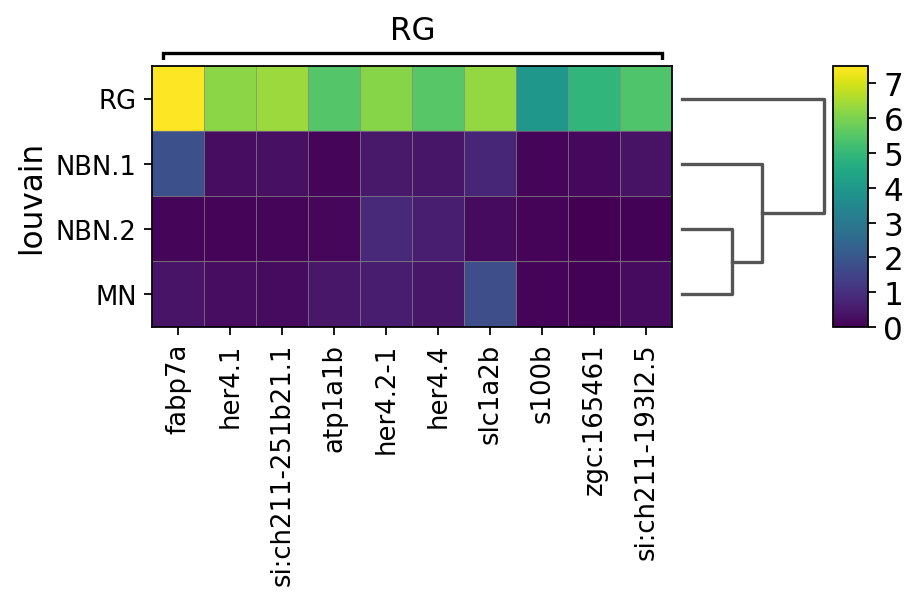

NBN.1 vs RG


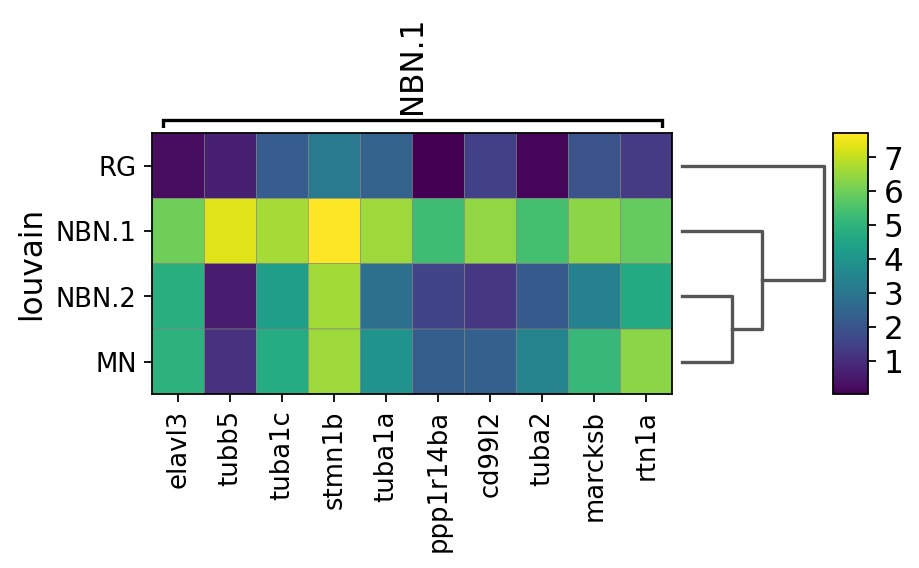

NBN.1 vs MN


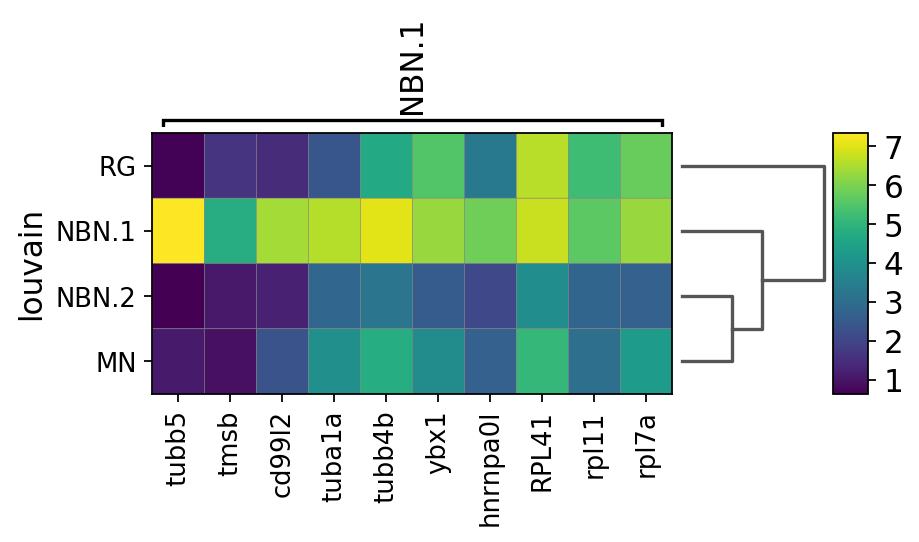

MN vs NBN.1


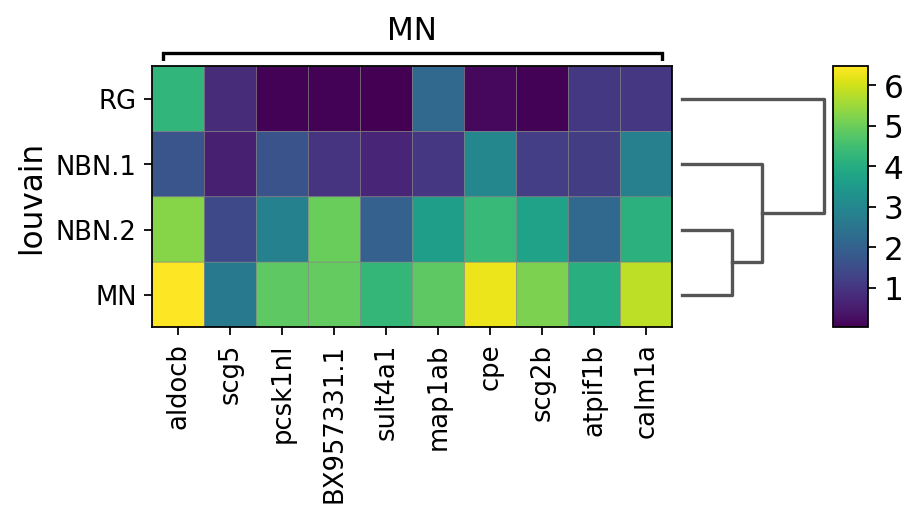

NBN.1 vs NBN.2


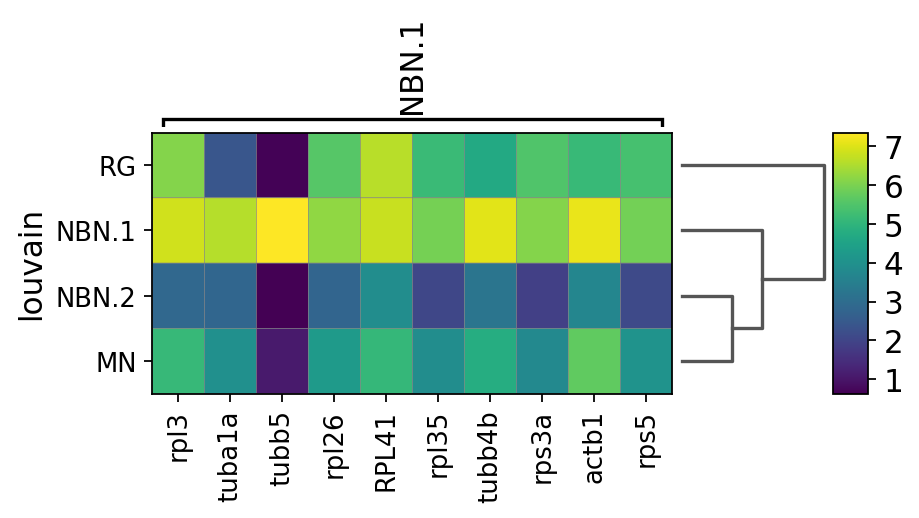

NBN.2 vs NBN.1


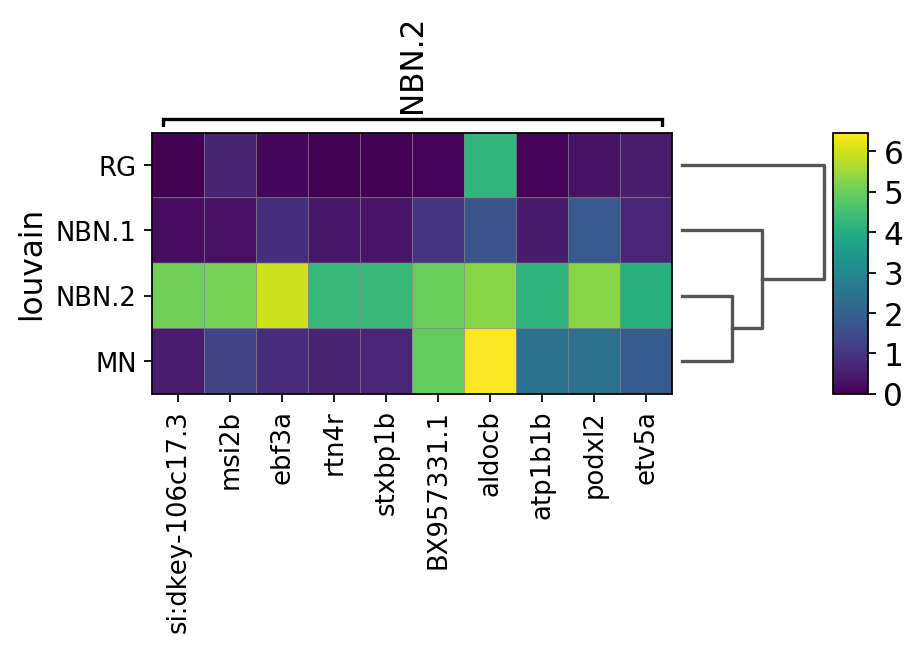

NBN.2 vs MN


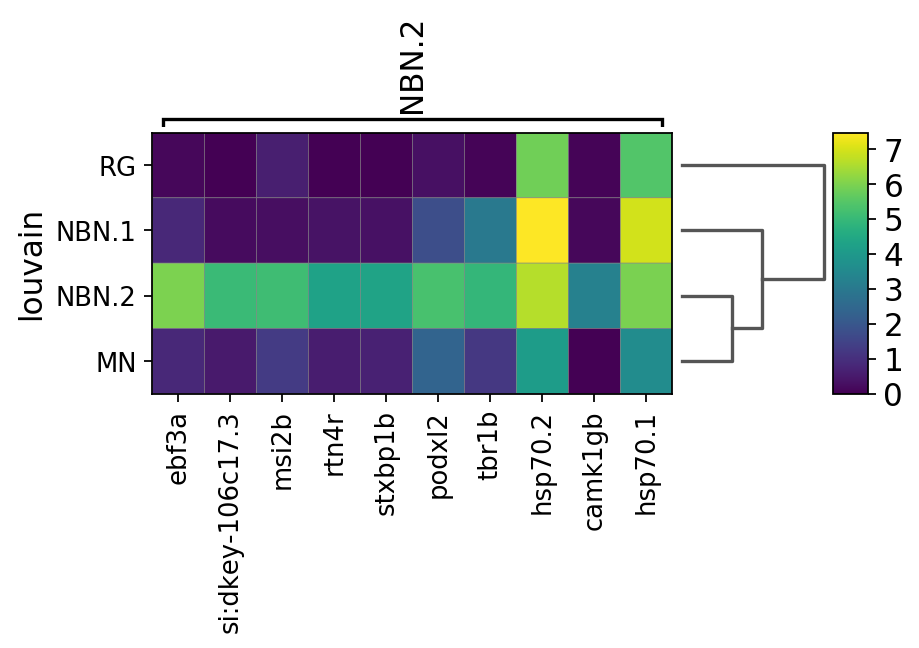

MN vs NBN.2


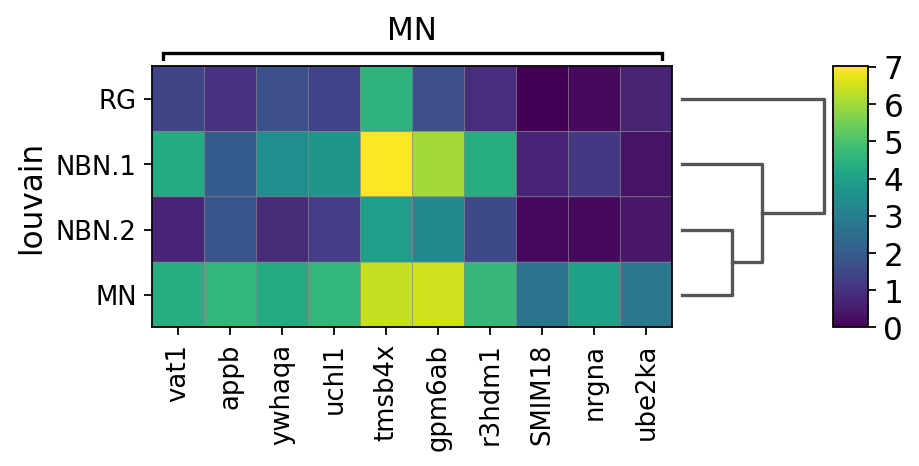

In [127]:
for group in groups:
    print(f'{group[0]} vs {group[1]}')
    sc.pl.rank_genes_groups_matrixplot(adata2, key=f'{group[0]} vs {group[1]}')
    group = group[::-1]
    print(f'{group[0]} vs {group[1]}')
    sc.pl.rank_genes_groups_matrixplot(adata2, key=f'{group[0]} vs {group[1]}')

# Gene expression along dpt

In [128]:
sc.pp.neighbors(adata2, n_neighbors=15, n_pcs=10)
sc.tl.paga(adata2, groups="louvain")

/home/fabrost/miniconda3/envs/spols180816d/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


## DEA genes

### Plot towards MN

In [129]:
genesMN = []
n_genes = 5
for group in [['RG', 'NBN.1'], ['NBN.1', 'MN']]:
    genesMN += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
    group = group[::-1]
    genesMN += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
genesMN = list(pd.Series(genesMN).drop_duplicates())

saving figure to file ./figures/paga_path_3E.pdf


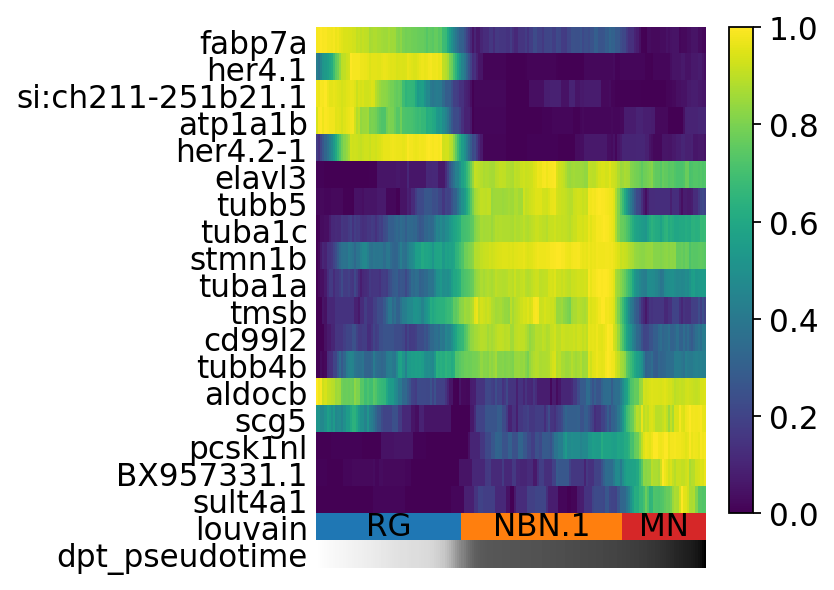

In [130]:
# fig = plt.figure(figsize=(4, 5))
sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'MN'], keys=genesMN, 
                groups_key='louvain', normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_3E')

### Plot towards NB

In [131]:
genes_NB = []
n_genes = 5
for group in [['RG', 'NBN.1'], ['NBN.1', 'NBN.2']]:
    genes_NB += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
    group = group[::-1]
    genes_NB += list(adata2.uns[f'{group[0]} vs {group[1]}']['names'][group[0]][:n_genes])
genes_NB = list(pd.Series(genes_NB).drop_duplicates())

saving figure to file ./figures/paga_path_3F.pdf


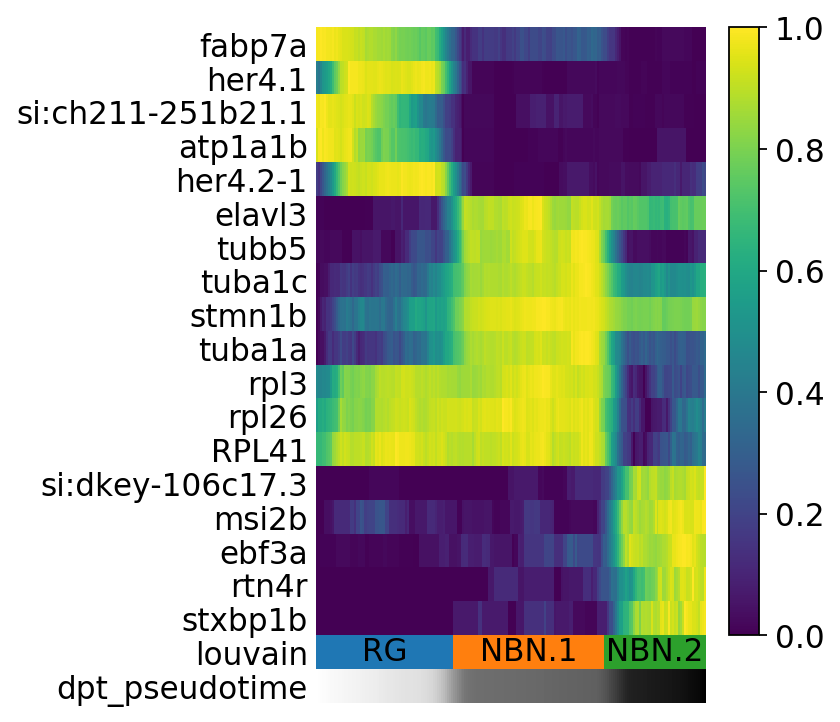

In [132]:
fig = plt.figure(figsize=(4, 5))
sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'NBN.2'], keys=genes_NB, groups_key='louvain', normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_3F')

## Curated Genes

In [133]:
hergenes = ['her2', 'her4.1', 'her4.2', 'her4.4', 'her15.1', 'her15.2']

In [134]:
genes_along_dpt = hergenes + markers['pseudotime']

### Towards MN

saving figure to file ./figures/paga_path_4A.pdf


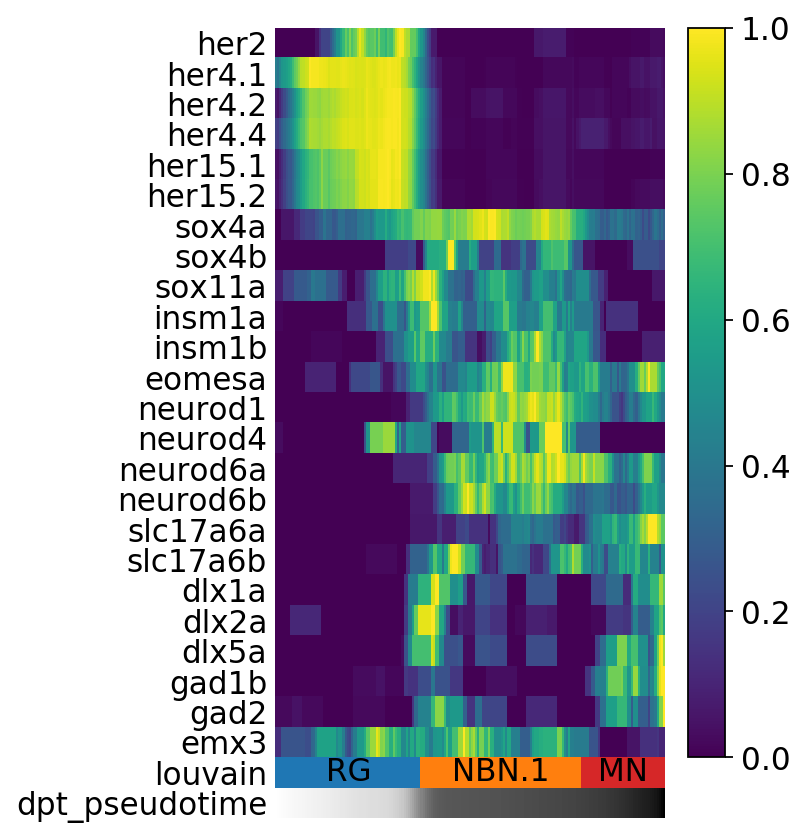

In [135]:
fig = plt.figure(figsize=(4,6))
ax = sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'MN'], keys=genes_along_dpt , groups_key='louvain', 
                normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_4A')

### Towards NBN.2

saving figure to file ./figures/paga_path_4B.pdf


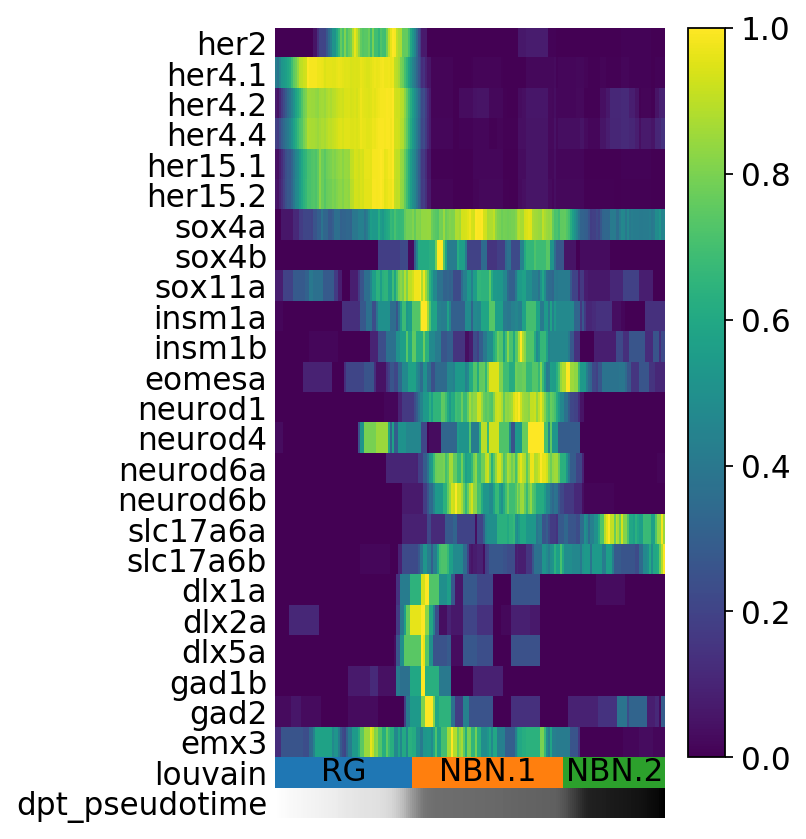

In [136]:
fig = plt.figure(figsize=(4,6))
sc.pl.paga_path(adata2, ['RG', 'NBN.1', 'NBN.2'], keys=genes_along_dpt, groups_key='louvain', 
                normalize_to_zero_one=True,
               as_heatmap=True, n_avg=15, save='_4B')